In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import emcee
from astropy.io import fits
import pandas as pd
import scipy.stats as st
from astropy.table import Table
import glob, os

In [2]:
def get_individual_transits(df,period):
    """
    Function which extracts each of the individual transits from the light curve
    """
    init = df.TIME[0]
    flux_data = []
    flux_model = []
    phase = []
    transits = 0
    final = 0
    while init<max(df.TIME):
        new = df.query('@init<TIME<@period+@init')
        new.reset_index(inplace=True)
        pos_i = new.index[(new.MODEL_INIT<0)]
        if len(pos_i)>20:
            left = pos_i[0]-10
            right = pos_i[-1]+10
            data = new.LC_DETREND[left:right]
            if len(data[np.isnan(data)])<len(data)*0.2:
                flux_data.append(data)
                flux_model.append(new.MODEL_INIT[left:right])
                phase.append(new.PHASE[left:right])
                transits+=1
        init = max(new.TIME)
        
    return flux_data,flux_model,phase,transits

def get_outliers_perc(data):

    """
    Function which computes the number of outliers for a given transit
    """
    tmp = data[data==data]
    if(tmp.size < 1):
        return -1, -1, -1
    iqr = st.stats.iqr(tmp)
    med = np.median(tmp)
    outlier_values = tmp[(tmp < med - 3*iqr) | (tmp > med + 3*iqr)]
    outlier_perc = outlier_values.size/tmp.size
    return outlier_perc,  med - 1.5*iqr, med + 1.5*iqr

In [3]:
periods = []
df = pd.DataFrame()
skew = []
kurt = []
mean = []
var = []
ad_test = []
outlier = []

transit_fluxes = []
transit_models = []
transit_phases = []
filenames = glob.glob("./confirmed/*.fits")
control_skew=[]
control_kurt=[]
control_ad=[]
#Load all fits files into pandas data frames
for file in filenames:

    dat = Table.read(file, format='fits')
    df = dat.to_pandas()
    #Extract the period of each transit from the data
    period = max(df.PHASE)-min(df.PHASE)
    periods.append(period)
    flux_data,flux_model,phase,transits = get_individual_transits(df,period)
    
    for i in range(transits):
        
        res = flux_data[i]-flux_model[i]
        transit_fluxes.append(flux_data[i])
        transit_models.append(flux_model[i])
        transit_phases.append(phase[i])
        
        tmp = res[res==res]
        mean.append(np.nanmean(tmp))
        var.append(np.nanvar(tmp))
        skew.append(st.skew(tmp,nan_policy='omit'))
        kurt.append(st.kurtosis(tmp,nan_policy='omit'))
        
        cntrl = np.random.normal(np.nanmean(tmp),np.nanstd(tmp),len(tmp))
        
        control_skew.append(st.skew(cntrl,nan_policy='omit'))
        control_kurt.append(st.kurtosis(cntrl,nan_policy='omit'))
        control_ad.append(st.anderson(cntrl))
        ad_test.append(st.anderson(tmp))
        outlier.append(get_outliers_perc(res)[0])

519


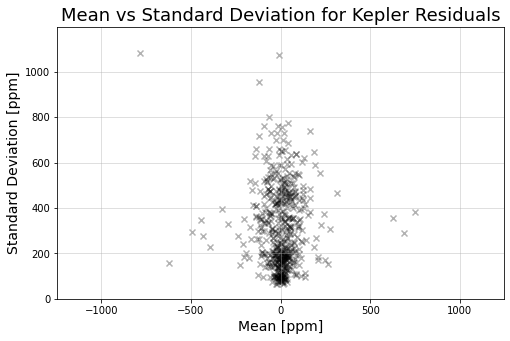

/home/jacob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


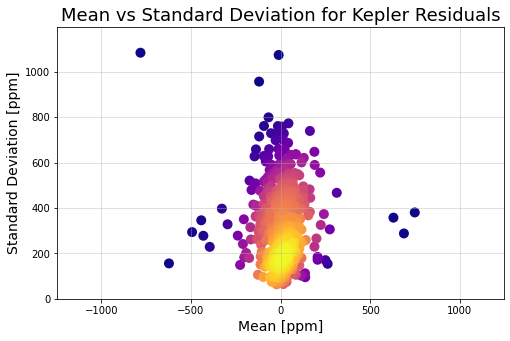

/home/jacob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


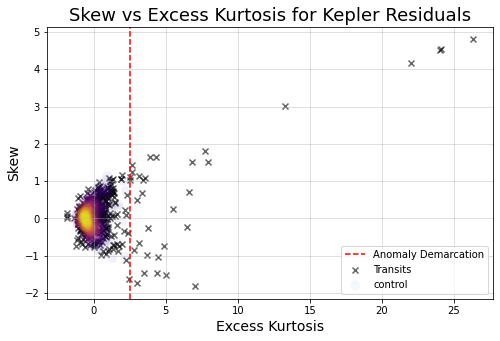

0.06358381502890173
[AndersonResult(statistic=0.28754243304231863, critical_values=array([0.533, 0.607, 0.728, 0.849, 1.01 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])), AndersonResult(statistic=0.1813181145857925, critical_values=array([0.533, 0.607, 0.728, 0.849, 1.01 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])), AndersonResult(statistic=0.4327425834618239, critical_values=array([0.533, 0.607, 0.728, 0.849, 1.01 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])), AndersonResult(statistic=0.8749845974825874, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])), AndersonResult(statistic=0.3617580768618822, critical_values=array([0.533, 0.607, 0.728, 0.849, 1.01 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])), AndersonResult(statistic=0.4328782668852753, critical_values=array([0.532, 0.606, 0.727, 0.848, 1.009]), significance_level=array([15. , 10. ,  5. ,  2.5,  1.

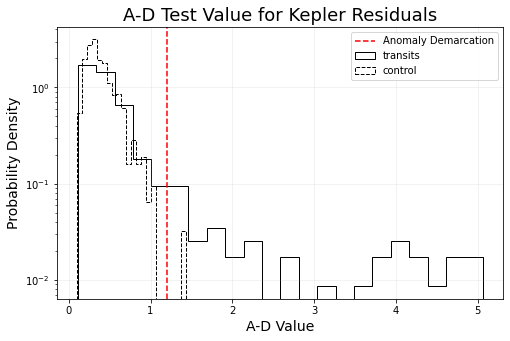

0.0789980732177264


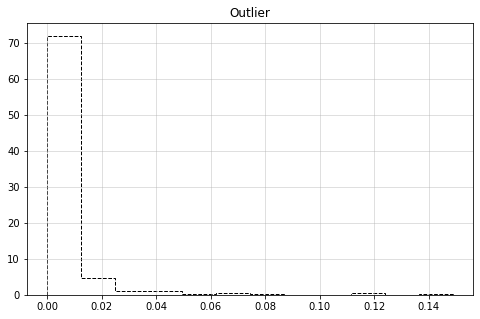

-0.2410541737973544 -0.06868176847021923


In [4]:
kurt = np.array(kurt)
print(kurt.size)
skew = np.array(skew)
ad = np.array(tmp)
outlier = np.array(outlier)

plt.figure(figsize=(8,5))
sd = np.sqrt(np.array(var))
mean = np.array(mean)
plt.scatter(1e6*mean,1e6*sd, marker='x', color='black', alpha = 0.3)
plt.grid(alpha=0.5)
plt.title('Mean vs Standard Deviation for Kepler Residuals',size=18)
plt.xlabel('Mean [ppm]',size=14)
plt.ylabel('Standard Deviation [ppm]',size=14)
plt.xlim(-3*np.std(1e6*mean),3*np.std(1e6*mean))
plt.ylim(0,3*np.std(1e6*sd))
plt.savefig("MeanVar.png")
plt.show()

from scipy.stats import gaussian_kde
x = 1e6*mean
y = 1e6*sd
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(8,5))
plt.scatter(x, y, c=z, s=100, edgecolor='', cmap='plasma')
#plt.colorbar()
plt.grid(alpha=0.5)
plt.title('Mean vs Standard Deviation for Kepler Residuals',size=18)
plt.xlabel('Mean [ppm]',size=14)
plt.ylabel('Standard Deviation [ppm]',size=14)
plt.xlim(-3*np.std(1e6*mean),3*np.std(1e6*mean))
plt.ylim(0,3*np.std(1e6*sd))
plt.savefig("MeanVar.png")
plt.show()

x = np.array(control_kurt)
y = np.array(control_skew)
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]


plt.figure(figsize=(8,5))

plt.scatter(kurt,skew, marker='x', color='black', alpha = 0.6,label="Transits")
plt.scatter(x, y, c=z, s=100, edgecolor='', cmap='plasma',alpha=0.05,label='control')
plt.grid(alpha=0.5)
plt.title('Skew vs Excess Kurtosis for Kepler Residuals',size=18)
plt.xlabel('Excess Kurtosis',size=14)
plt.ylabel('Skew',size=14)
plt.axvline(x=2.5,color='red',linestyle='--',label='Anomaly Demarcation')
plt.legend()
plt.savefig("SkewKurt.png")
plt.show()
print(kurt[kurt>=2.5].size/kurt.size)

plt.figure(figsize=(8,5))
tmp =[item[0] for item in ad_test]
tmp = np.array(tmp)
control_tmp =[item[0] for item in control_ad]
control_tmp = np.array(control_tmp)
plt.hist(tmp,int(np.sqrt(len(tmp))),density=True, histtype='step', color='k',linestyle='-',label='transits')
print(control_ad)
plt.hist(control_tmp,int(np.sqrt(len(control_tmp))),density=True, histtype='step', color='k',linestyle='--',label='control')
plt.grid(alpha=0.2)
plt.axvline(x=1.2, color = 'red',label='Anomaly Demarcation',linestyle='--')
plt.title('A-D Test Value for Kepler Residuals',size=18)
plt.xlabel("A-D Value",size=14)
plt.ylabel("Probability Density",size=14)
plt.yscale('log')
plt.legend()
plt.savefig("AD.png")
plt.show()
print(tmp[tmp > 1.2].size/tmp.size)

plt.figure(figsize=(8,5))
tmp =[item[0] for item in ad_test]
plt.hist(outlier,int(np.sqrt(len(outlier)))-10,density=True, histtype='step', color='k',linestyle='--')
plt.title('Outlier')
plt.grid(alpha=0.5)
plt.show()

print(np.median(control_kurt), np.median(kurt))

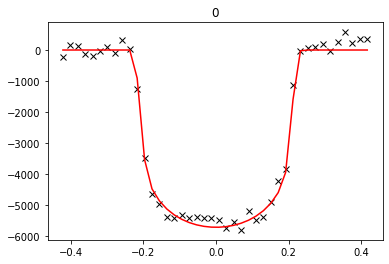

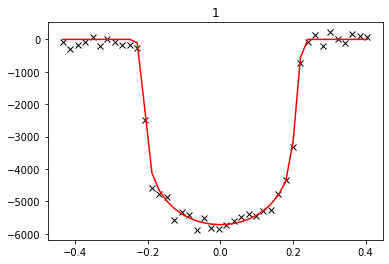

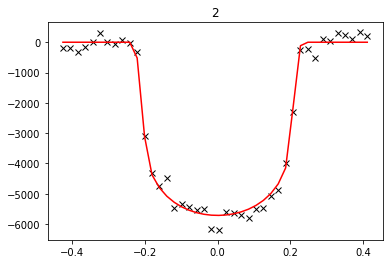

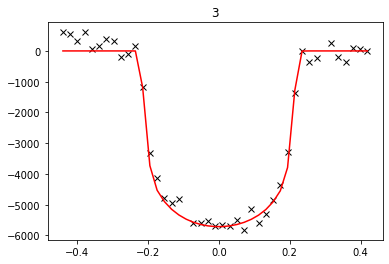

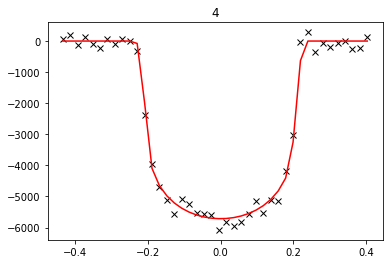

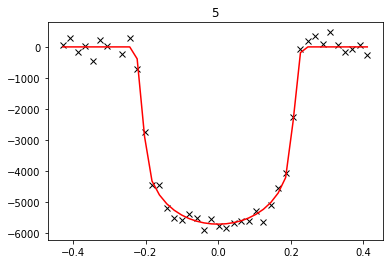

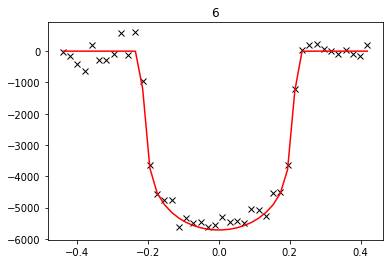

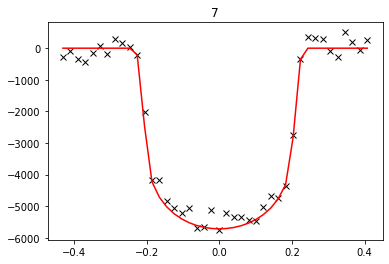

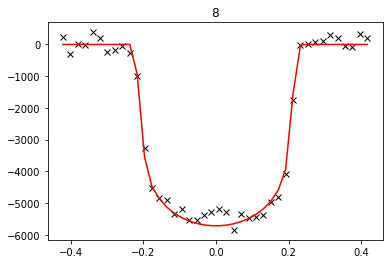

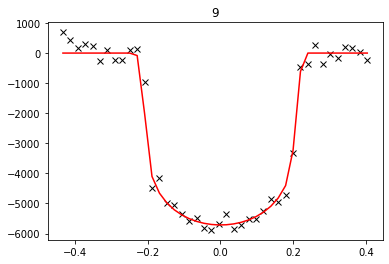

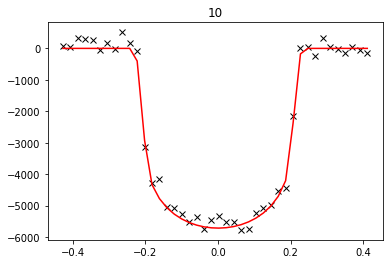

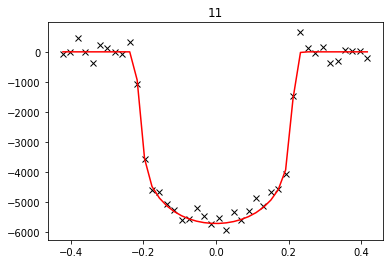

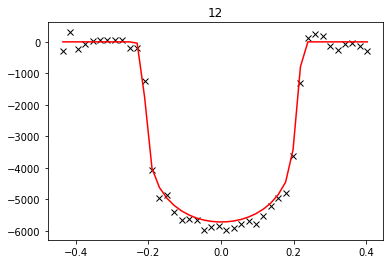

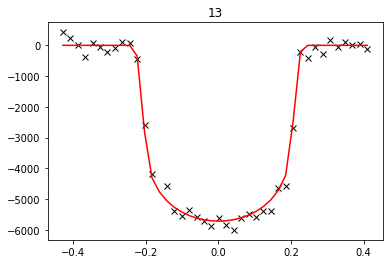

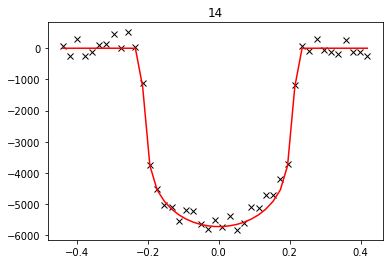

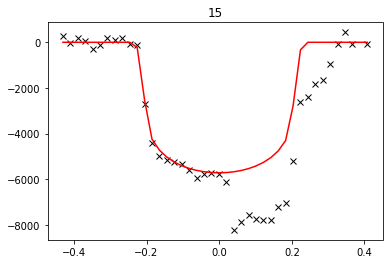

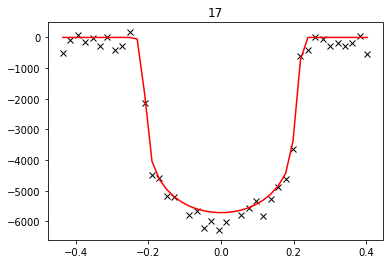

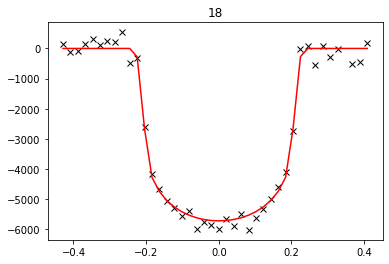

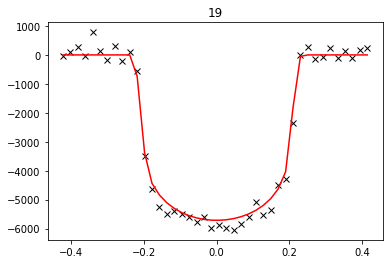

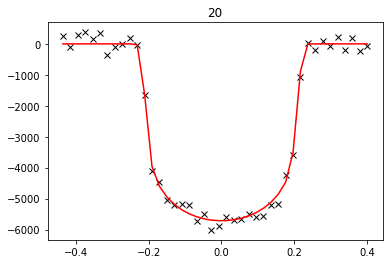

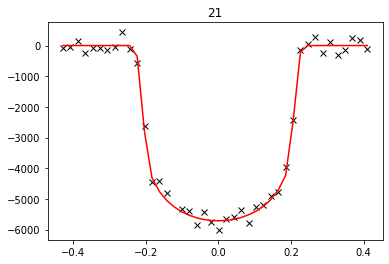

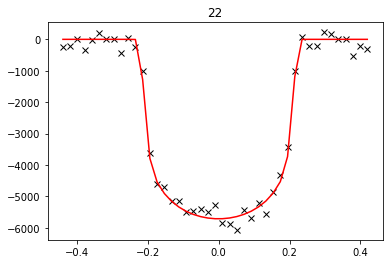

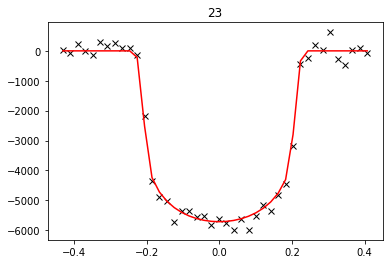

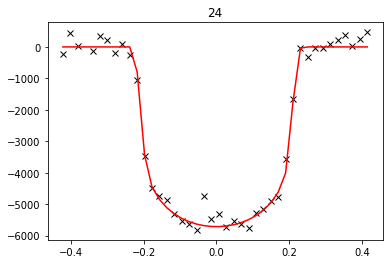

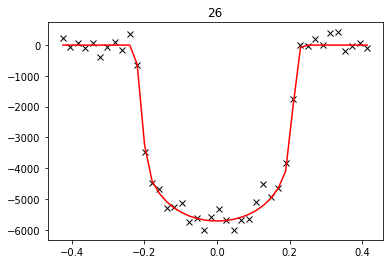

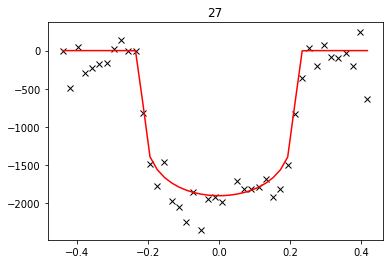

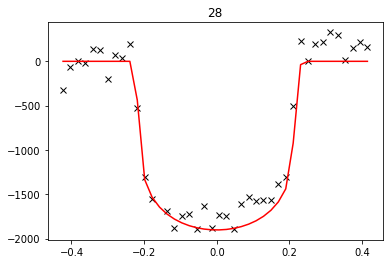

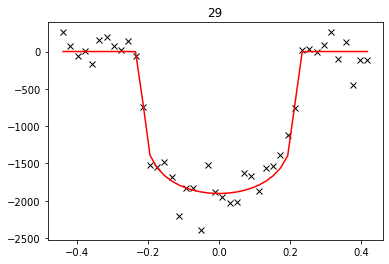

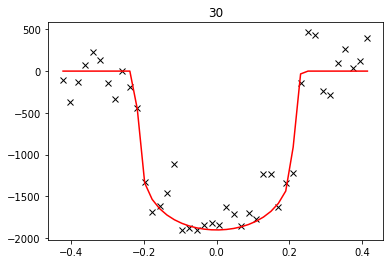

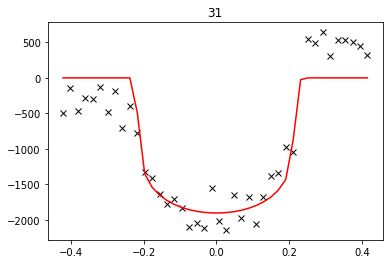

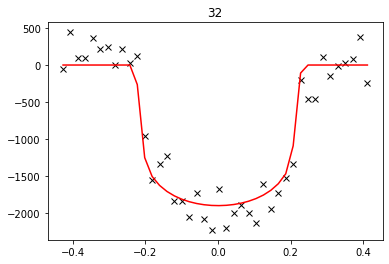

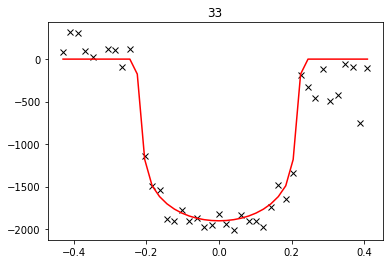

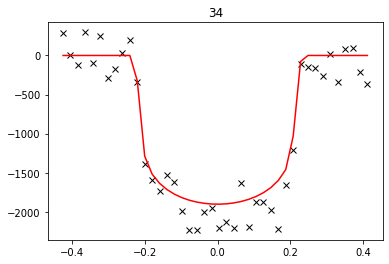

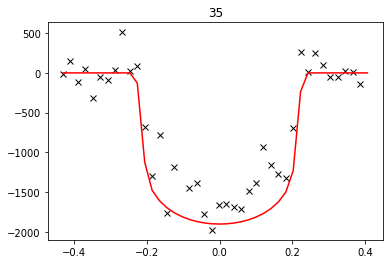

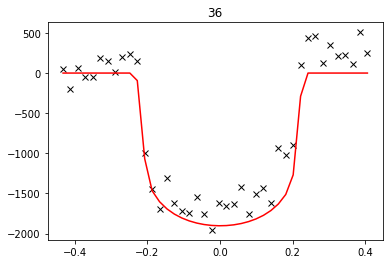

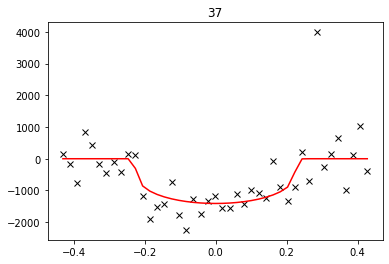

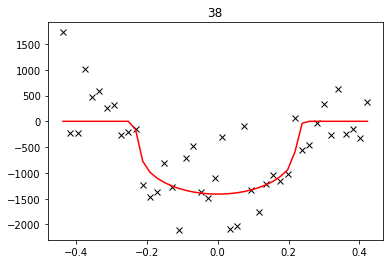

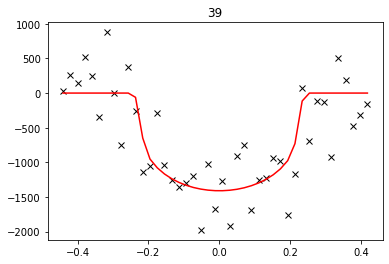

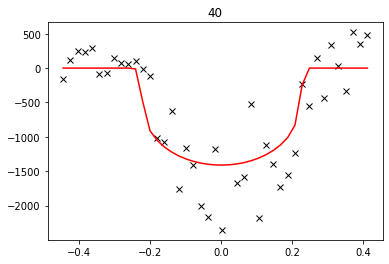

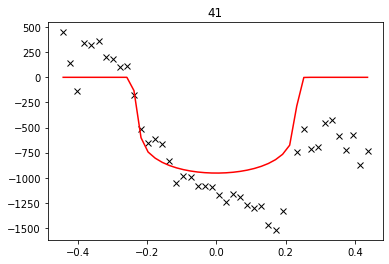

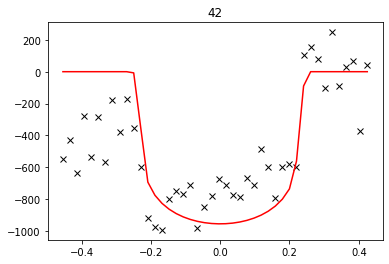

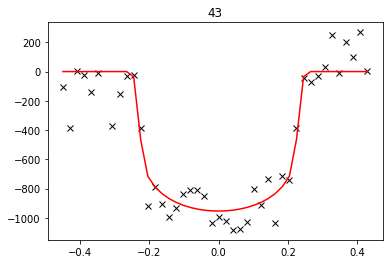

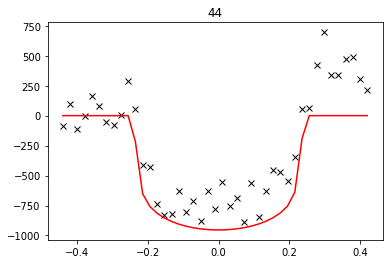

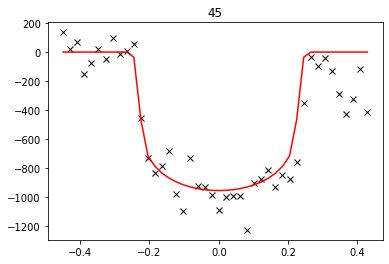

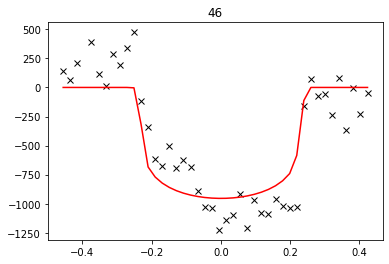

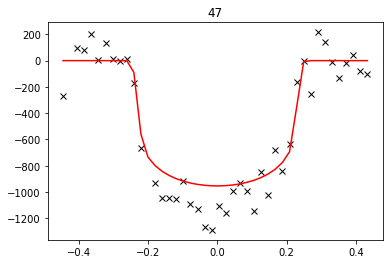

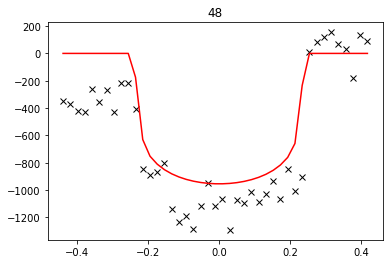

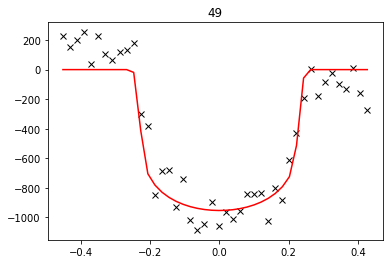

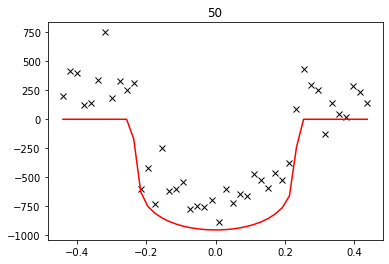

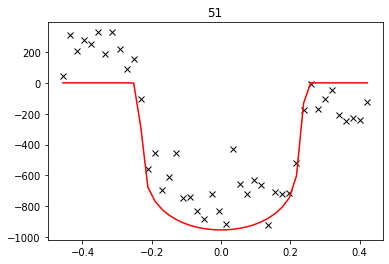

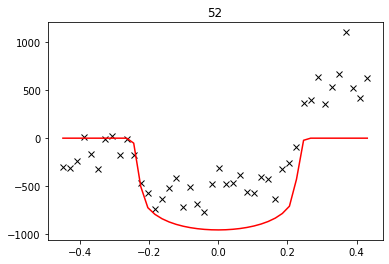

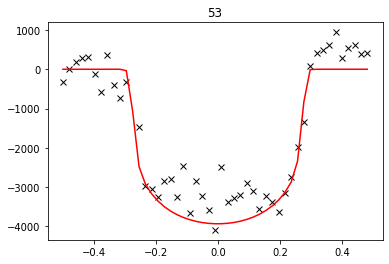

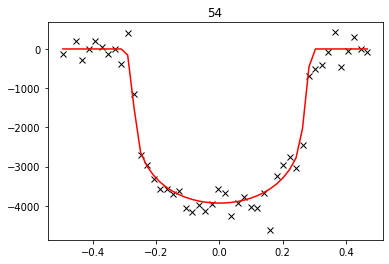

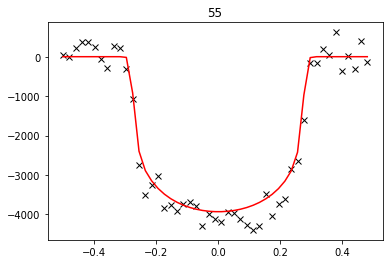

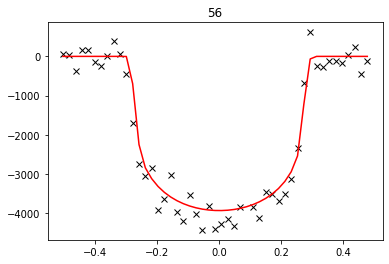

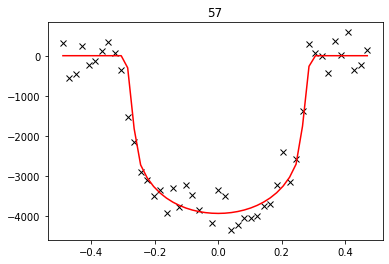

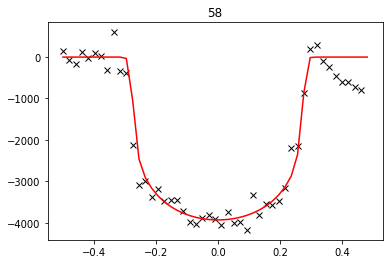

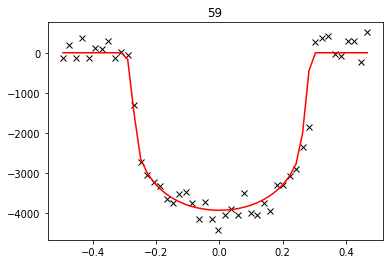

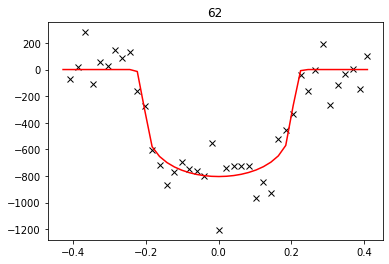

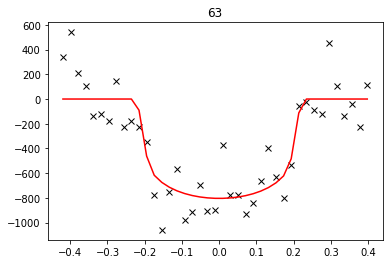

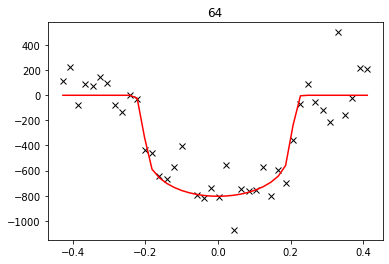

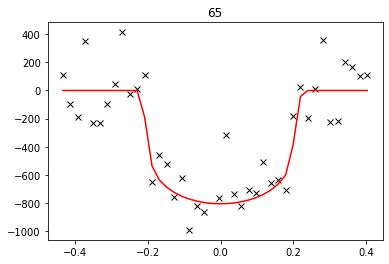

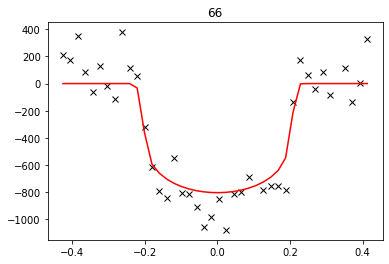

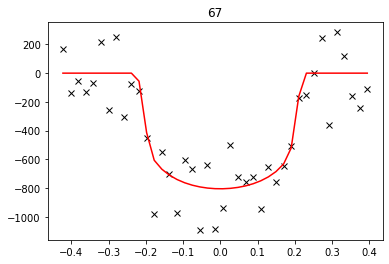

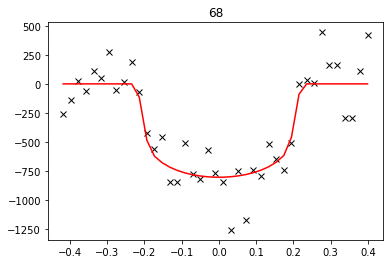

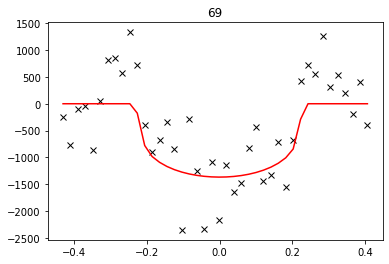

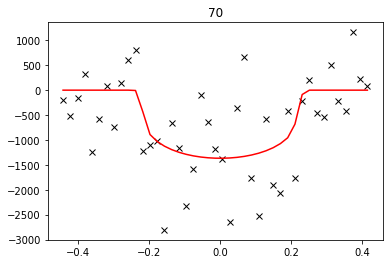

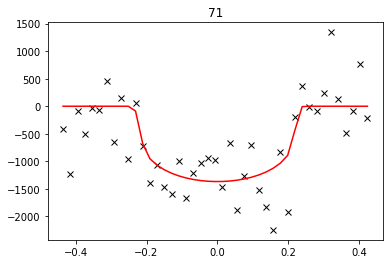

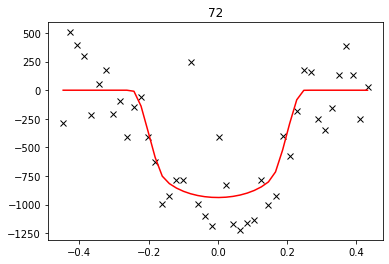

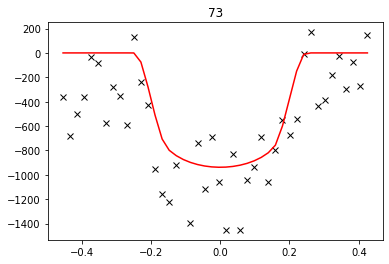

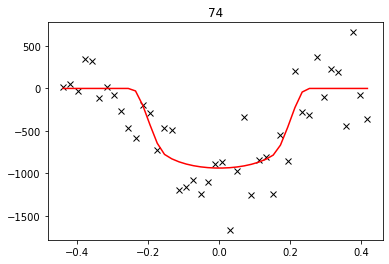

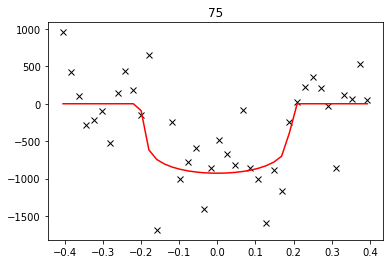

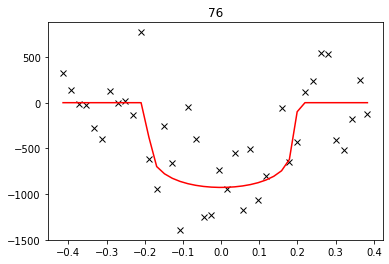

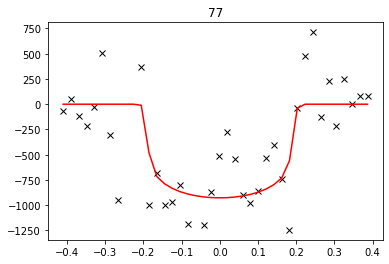

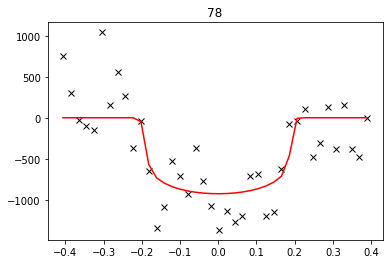

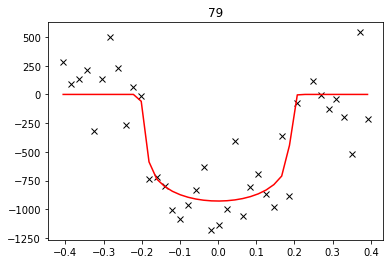

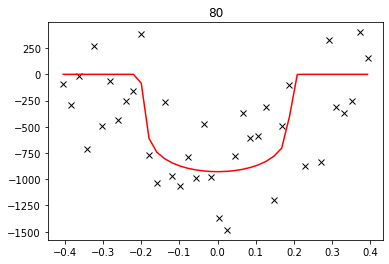

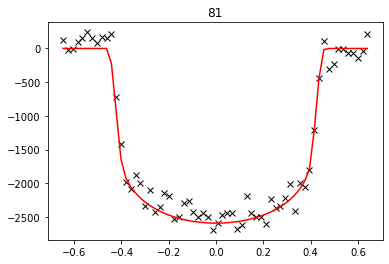

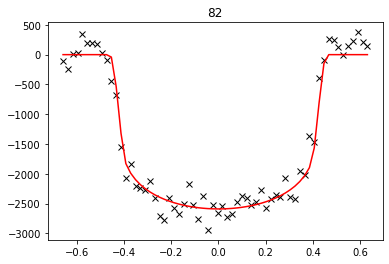

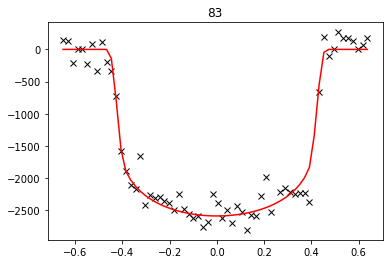

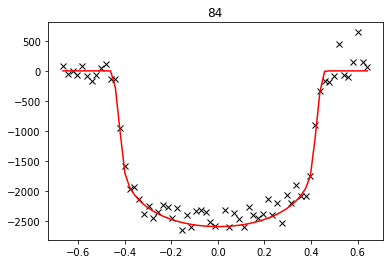

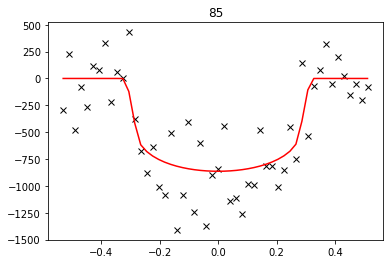

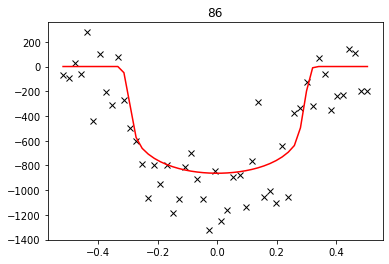

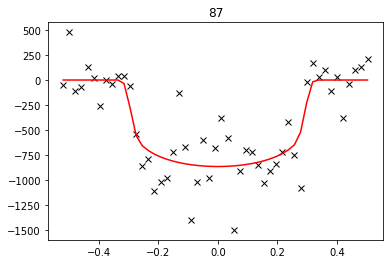

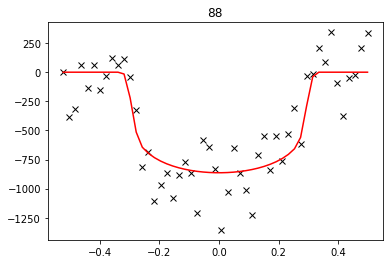

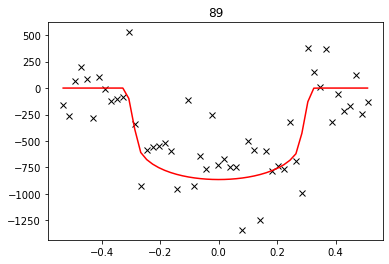

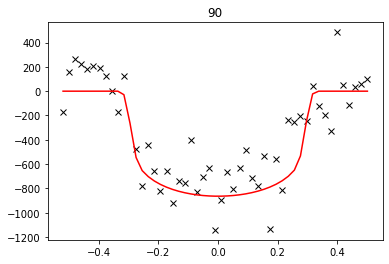

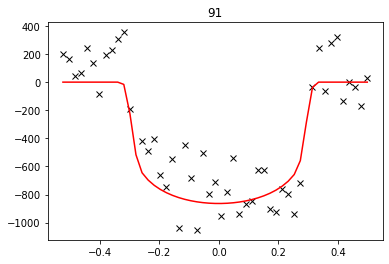

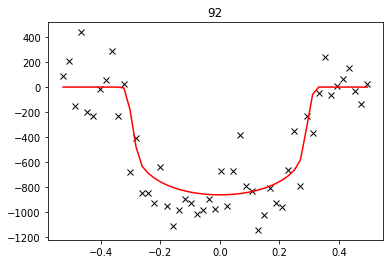

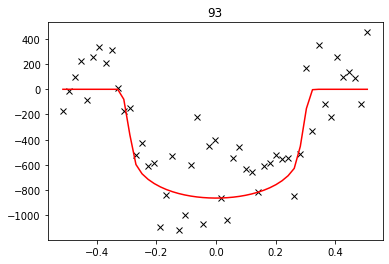

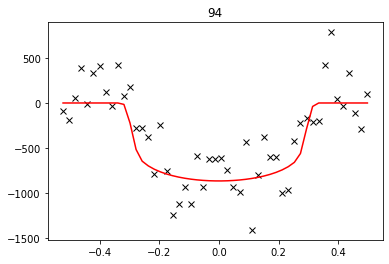

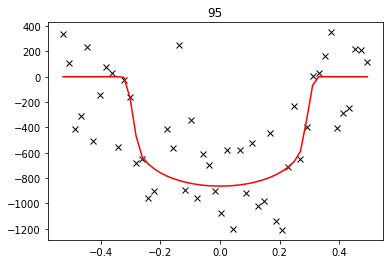

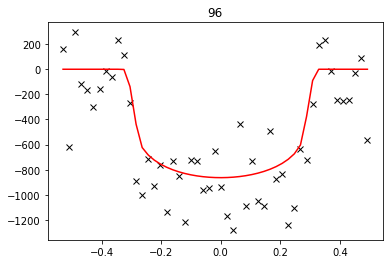

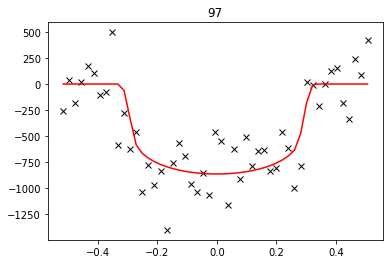

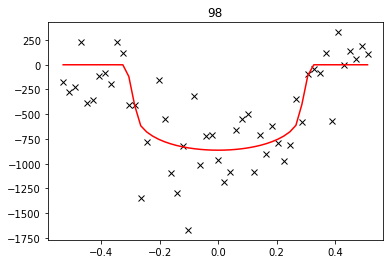

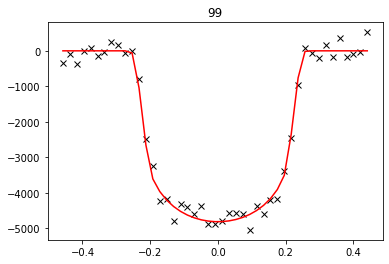

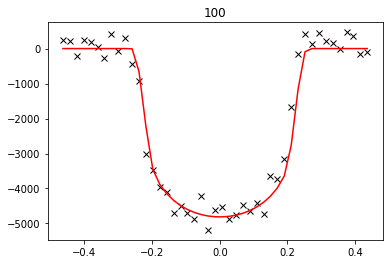

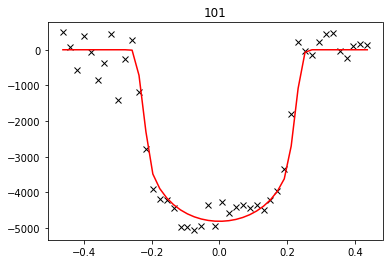

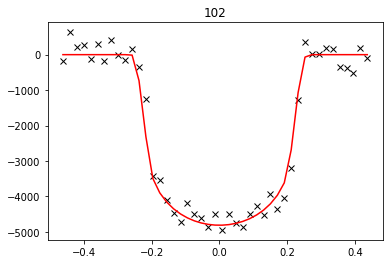

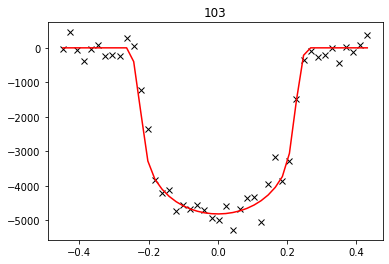

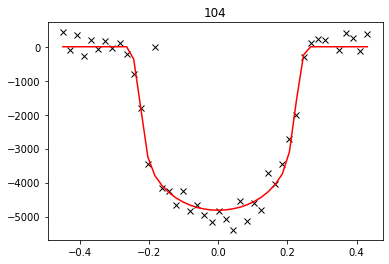

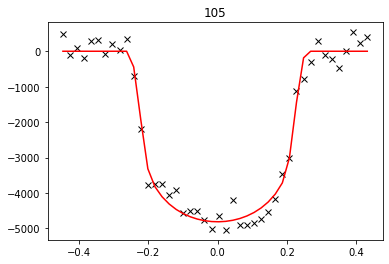

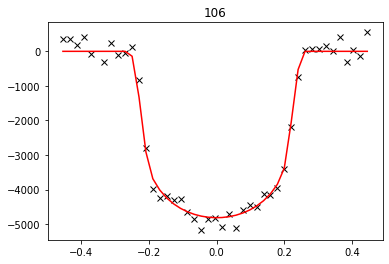

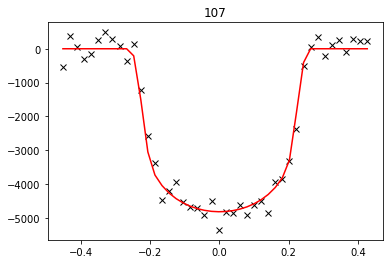

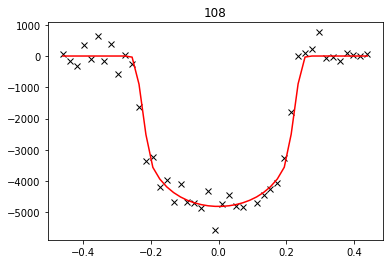

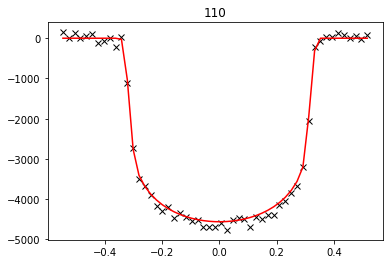

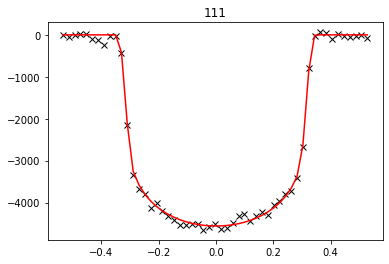

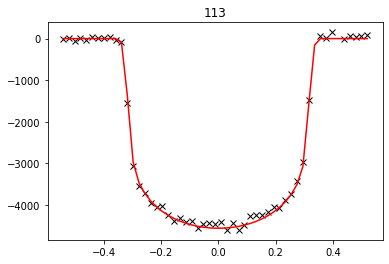

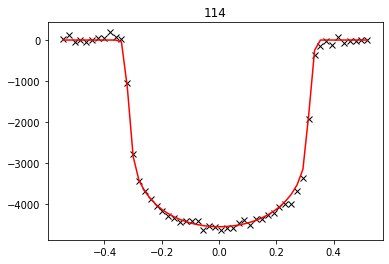

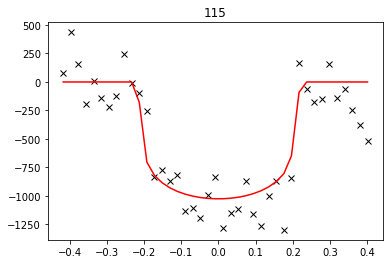

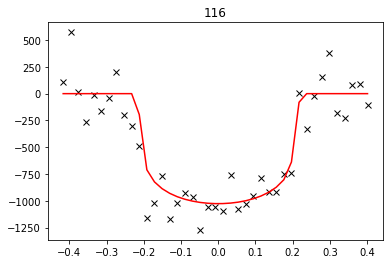

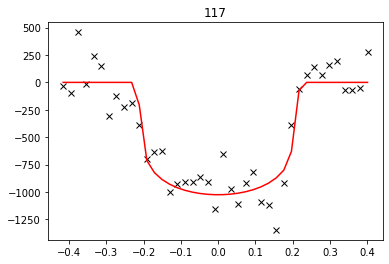

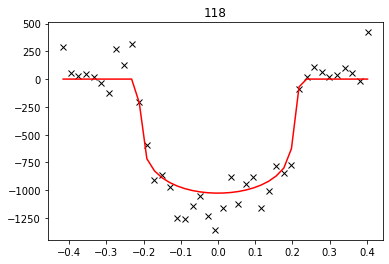

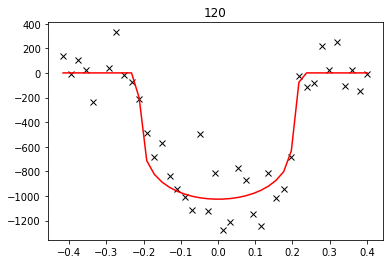

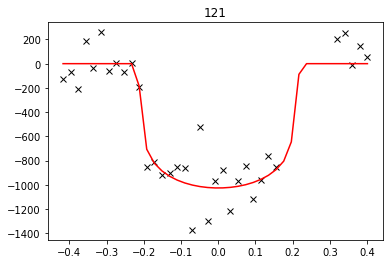

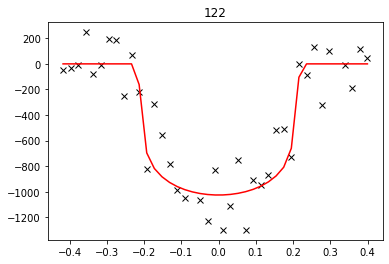

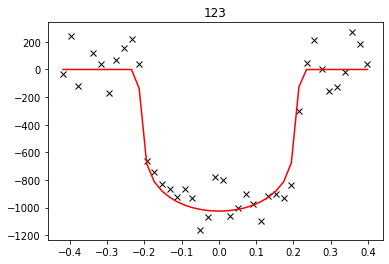

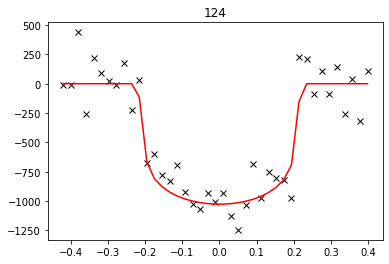

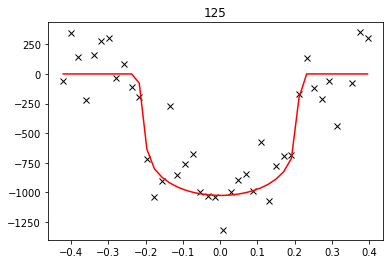

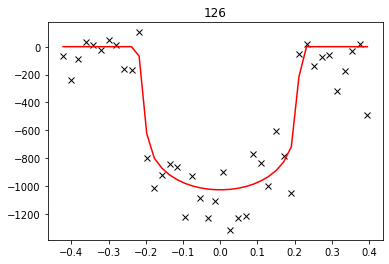

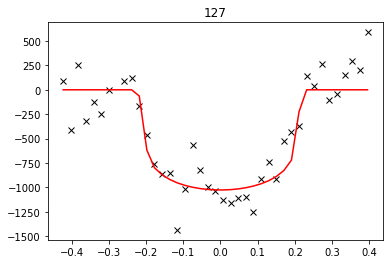

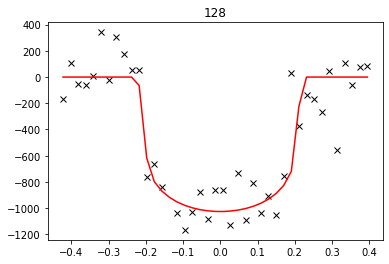

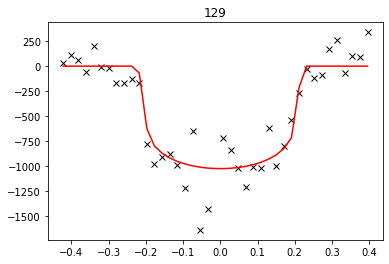

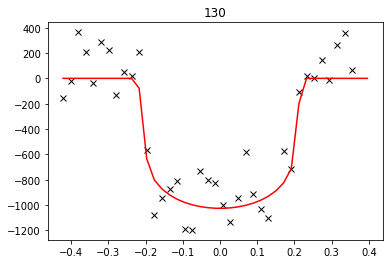

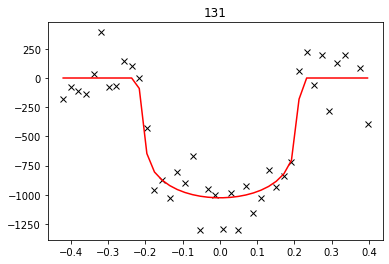

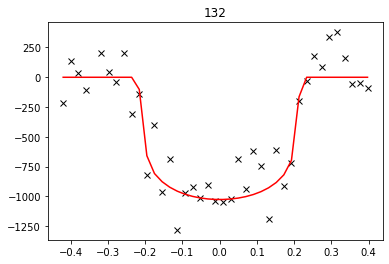

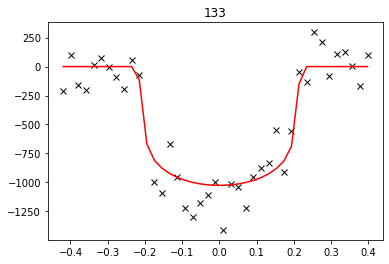

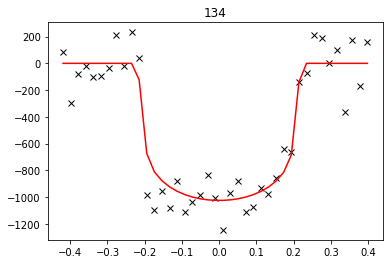

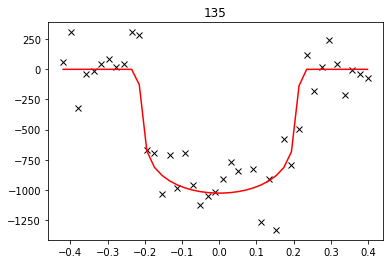

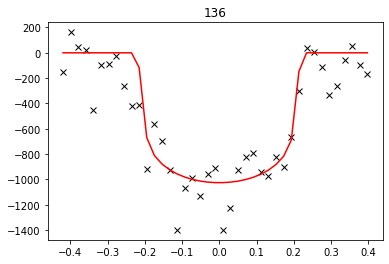

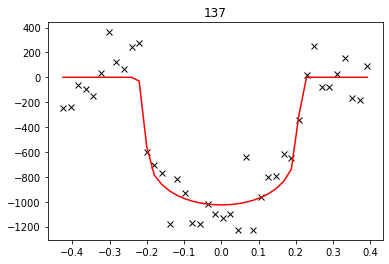

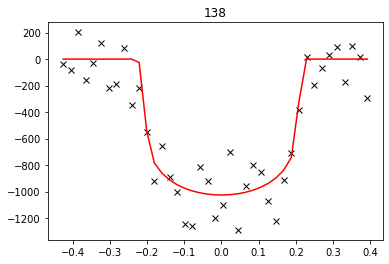

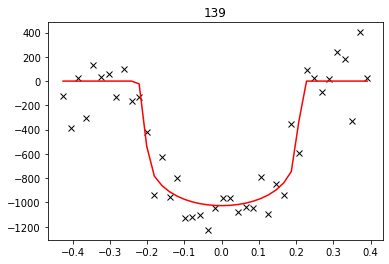

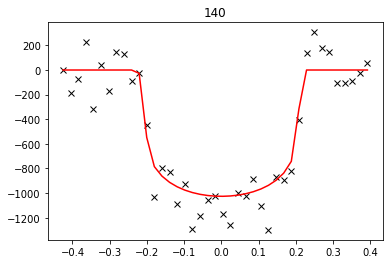

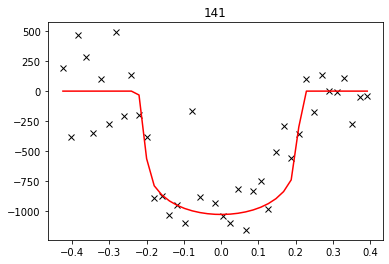

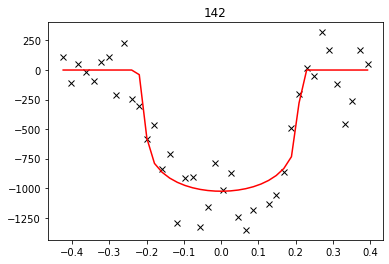

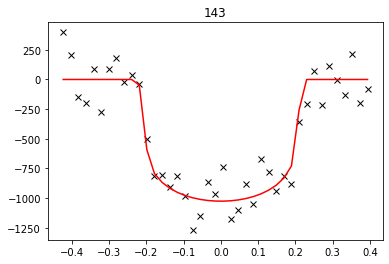

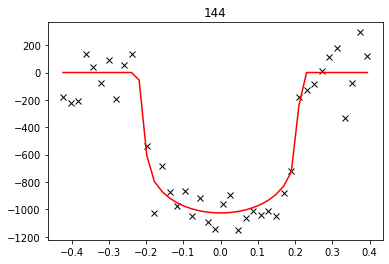

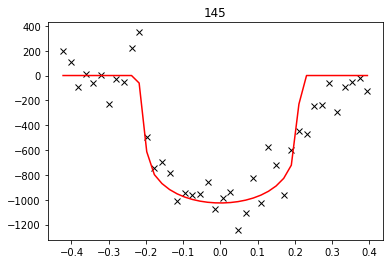

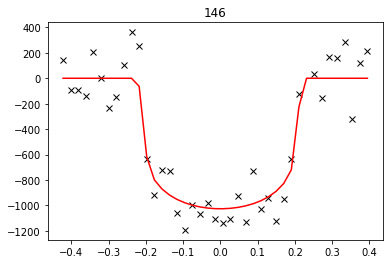

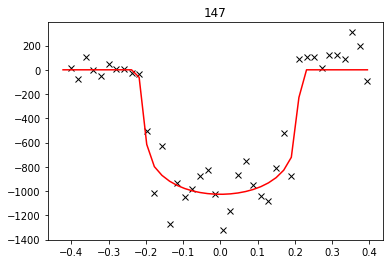

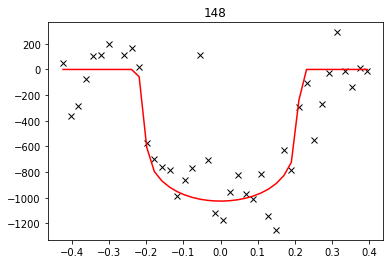

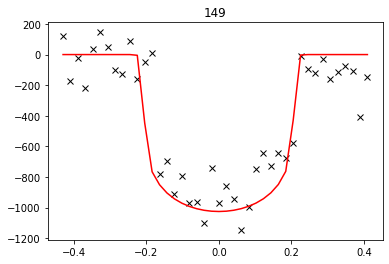

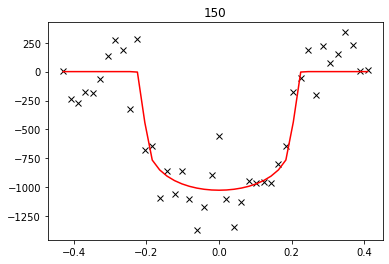

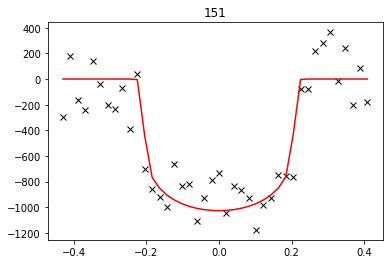

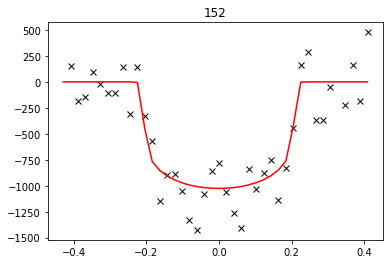

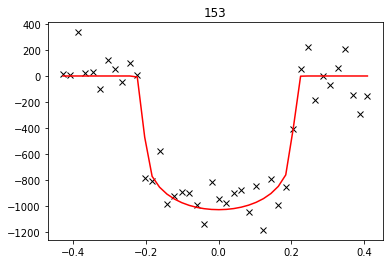

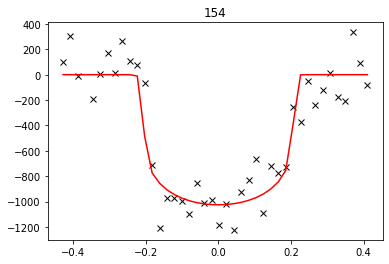

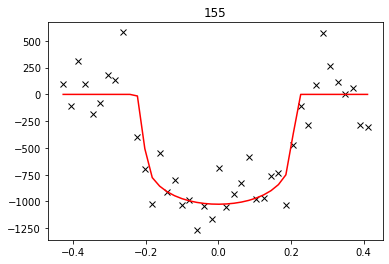

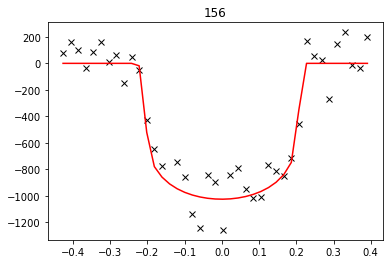

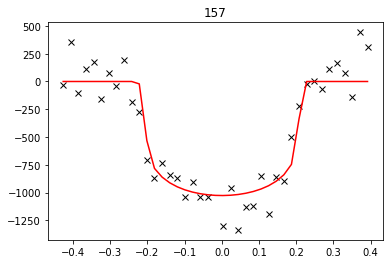

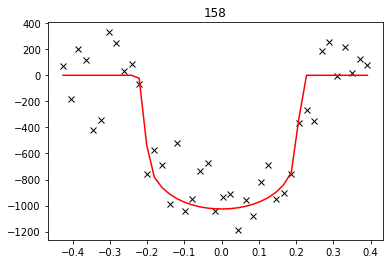

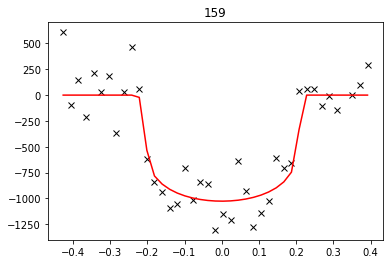

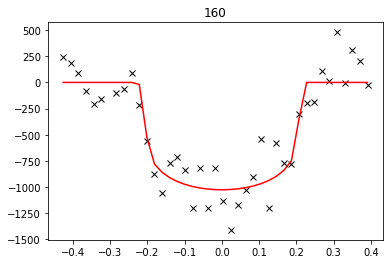

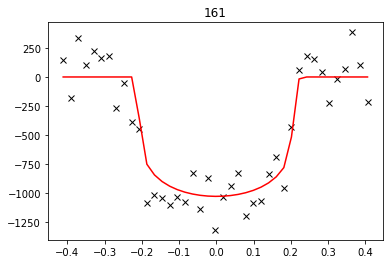

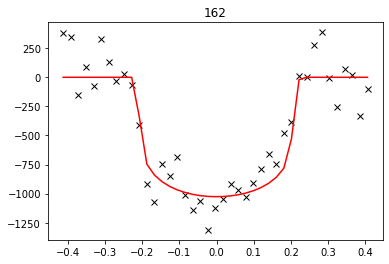

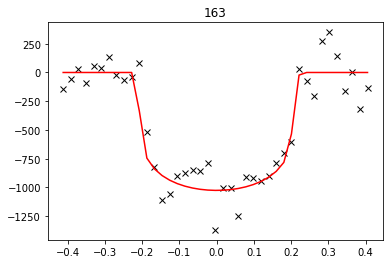

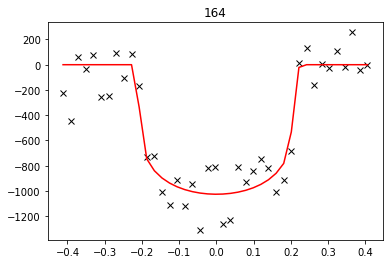

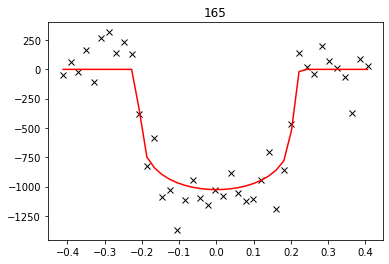

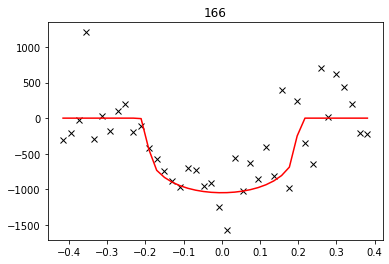

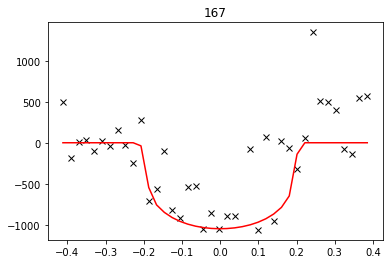

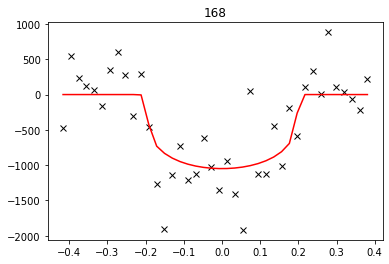

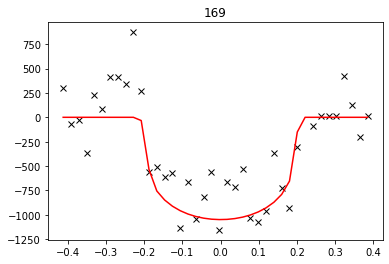

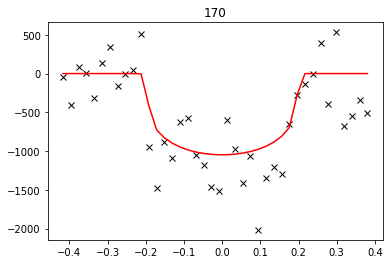

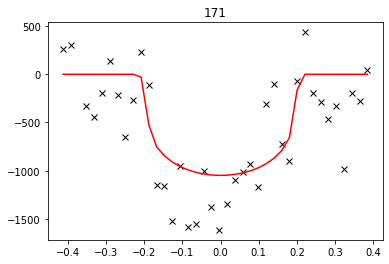

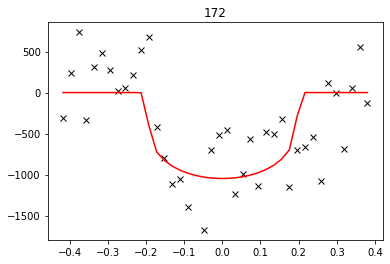

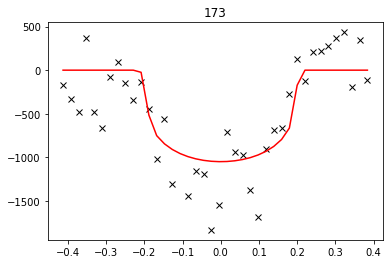

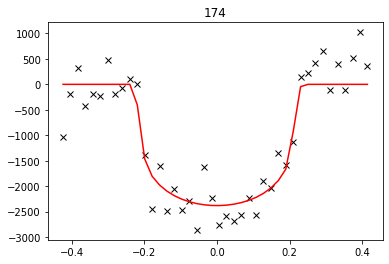

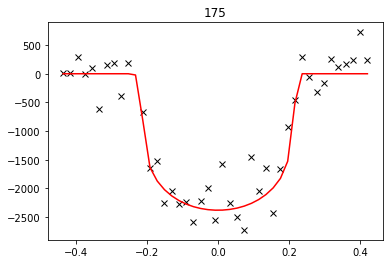

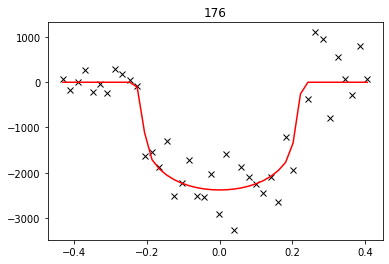

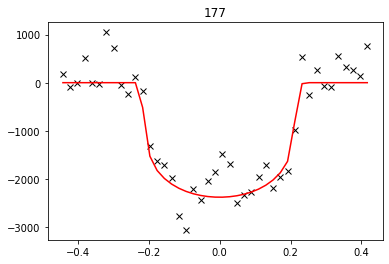

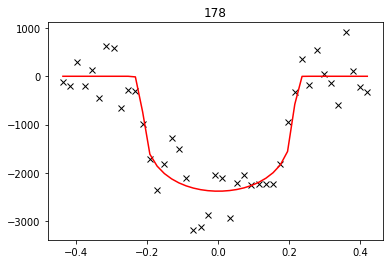

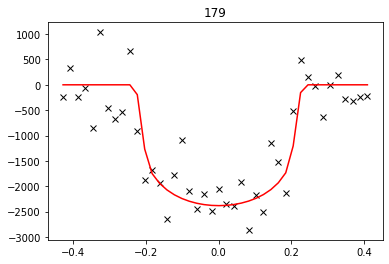

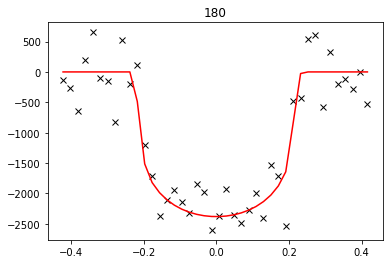

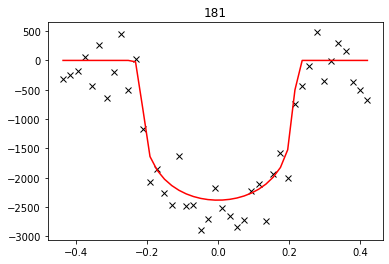

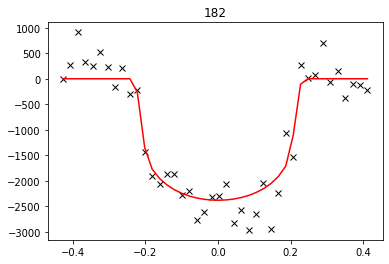

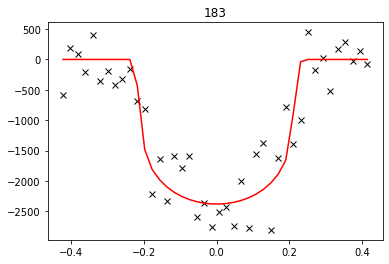

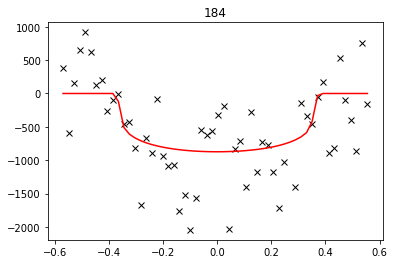

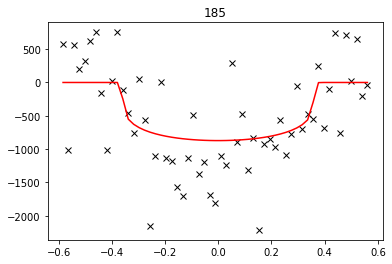

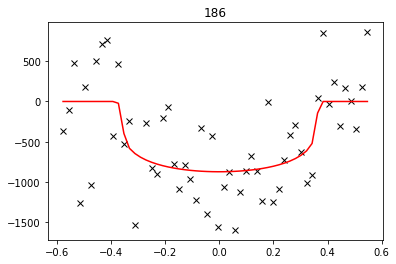

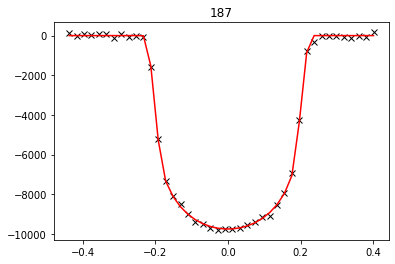

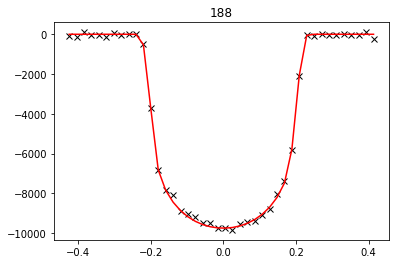

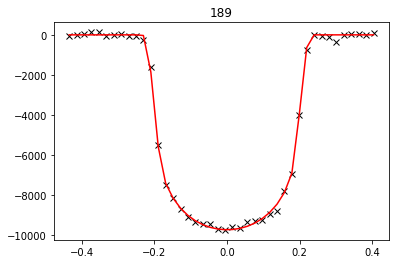

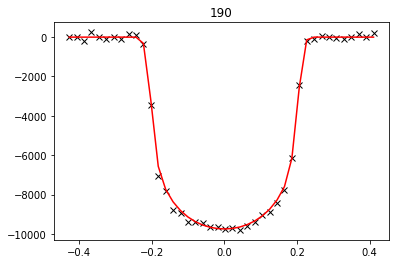

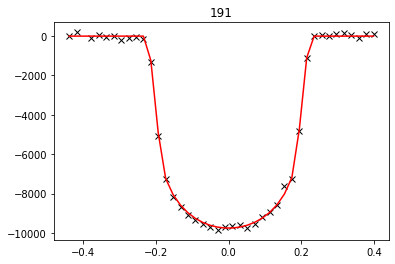

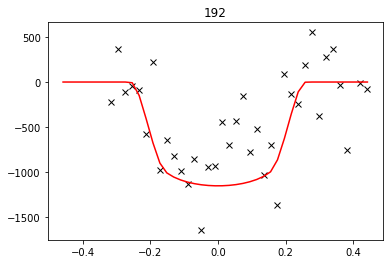

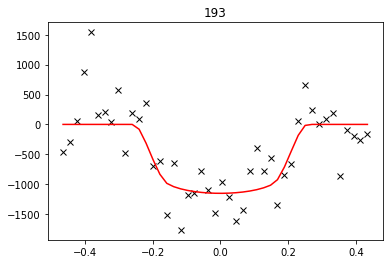

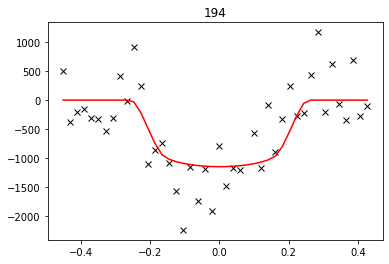

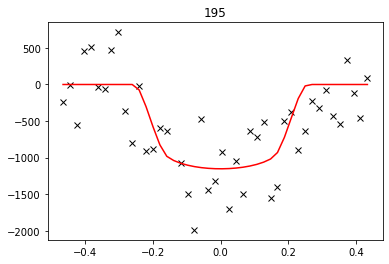

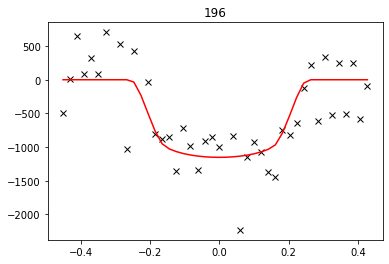

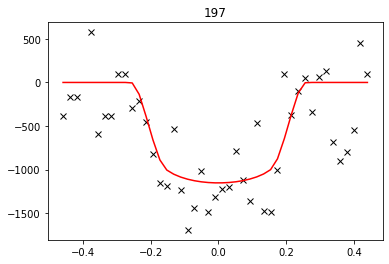

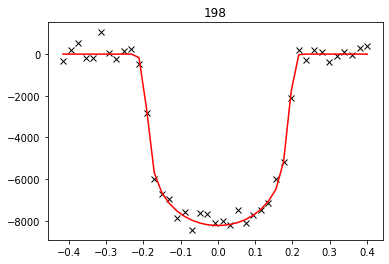

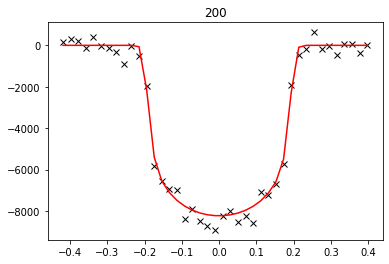

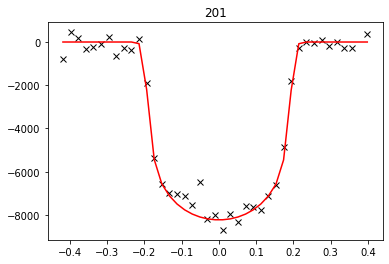

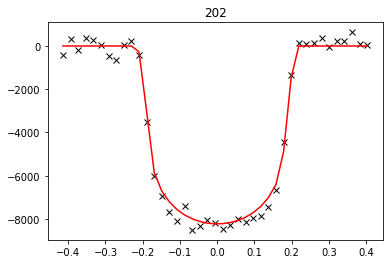

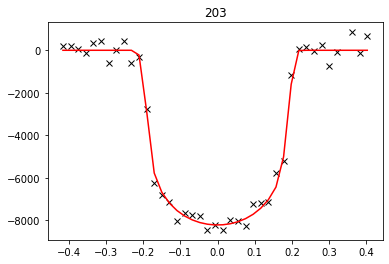

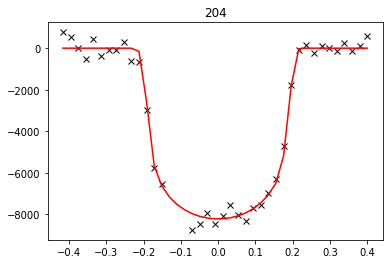

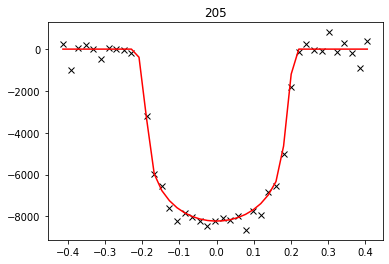

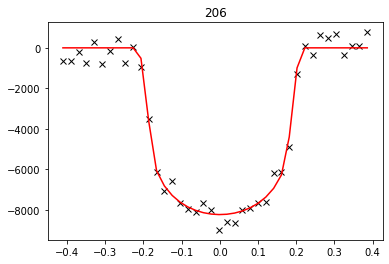

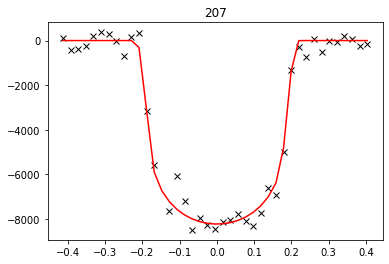

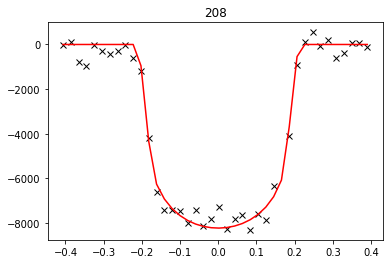

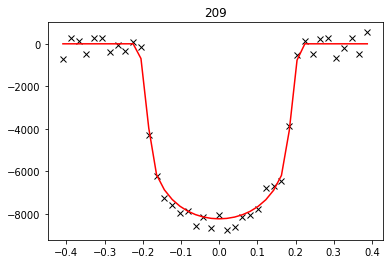

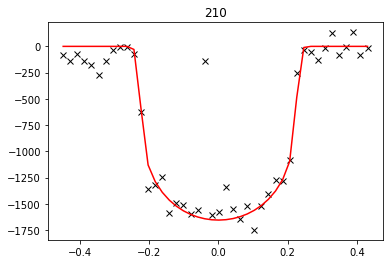

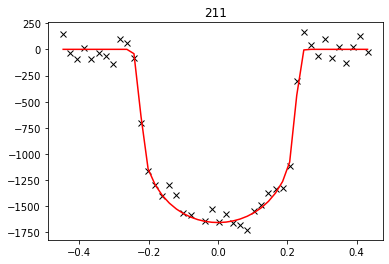

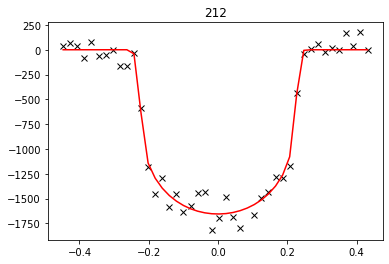

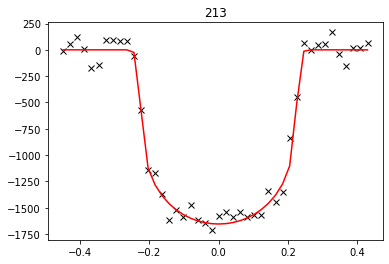

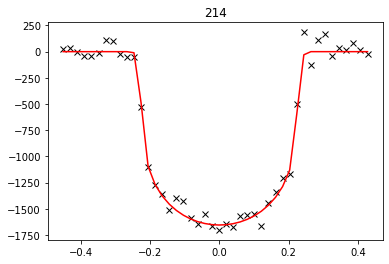

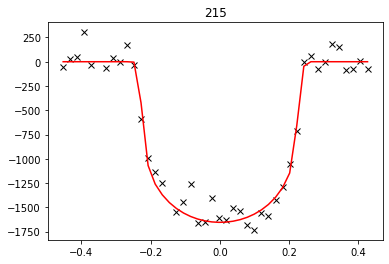

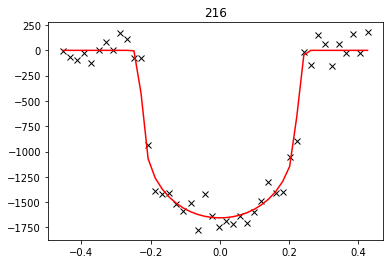

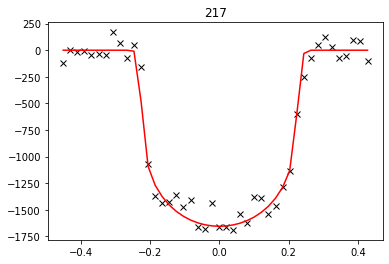

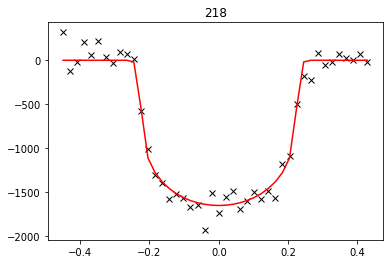

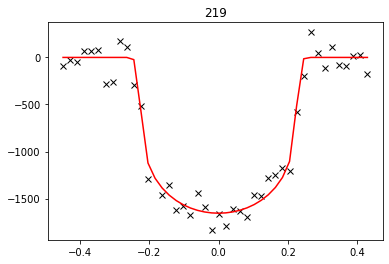

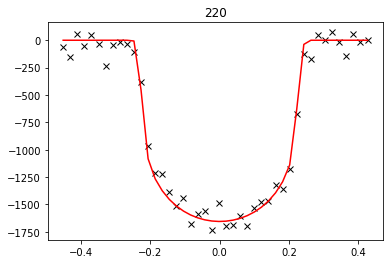

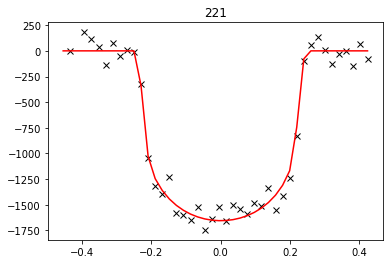

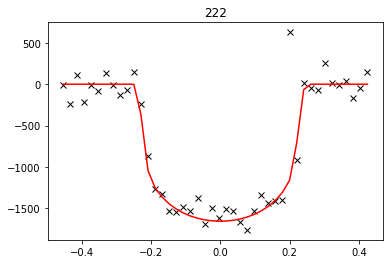

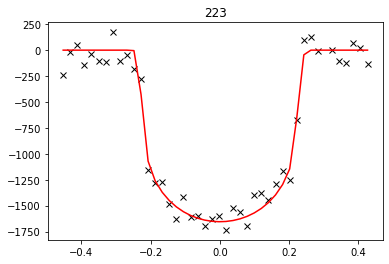

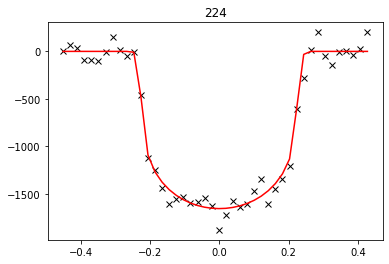

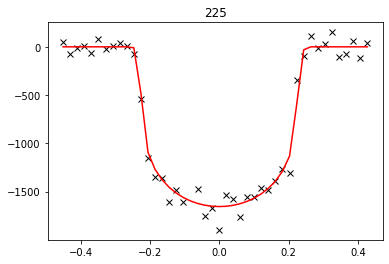

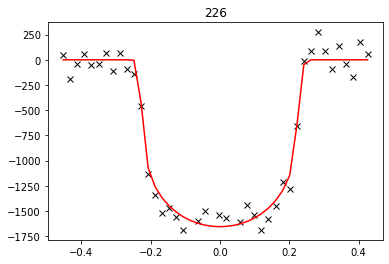

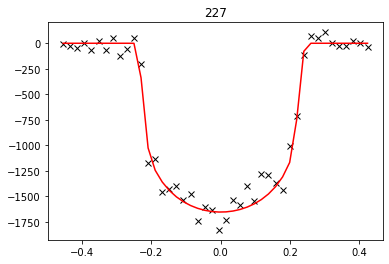

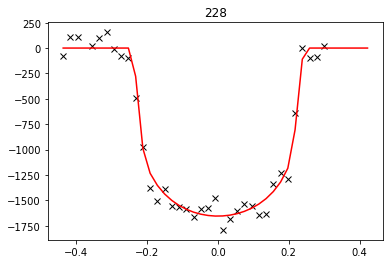

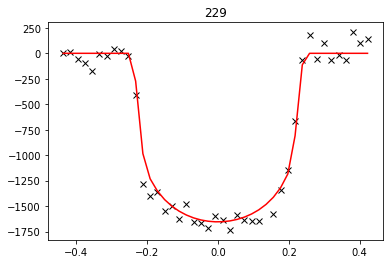

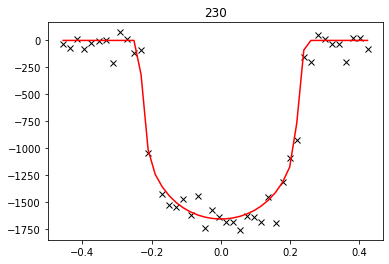

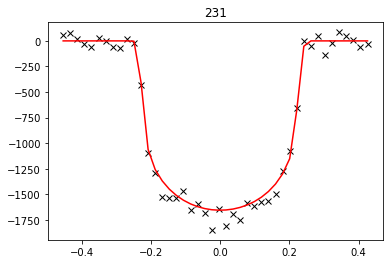

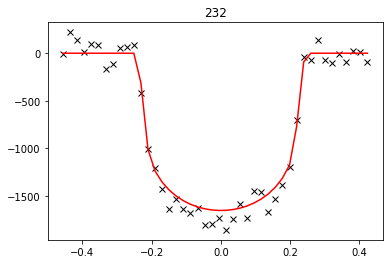

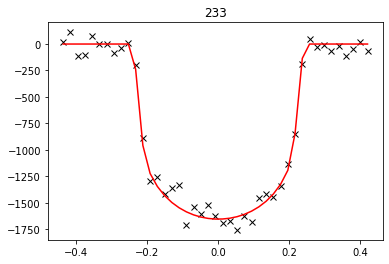

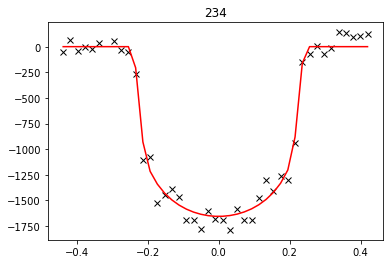

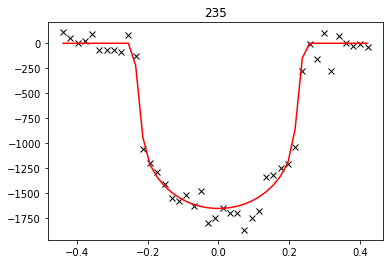

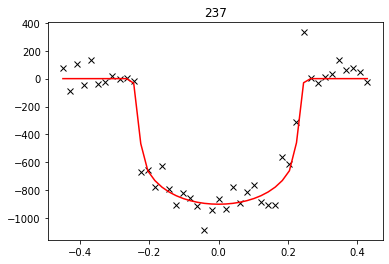

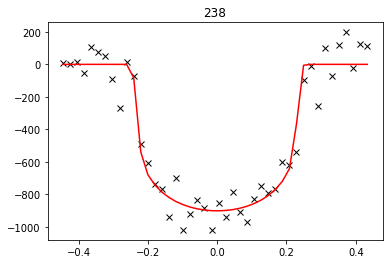

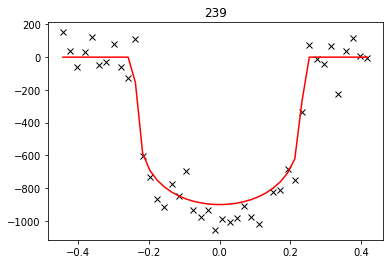

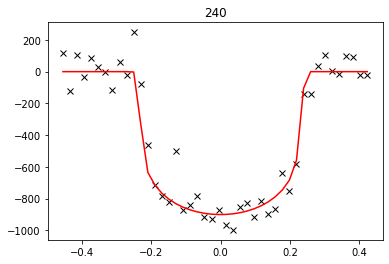

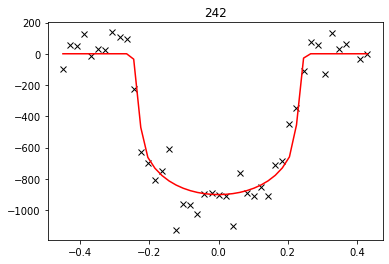

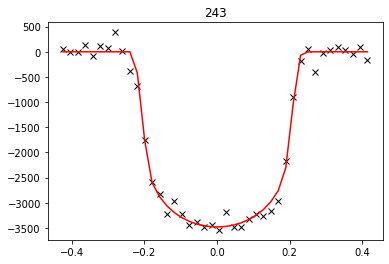

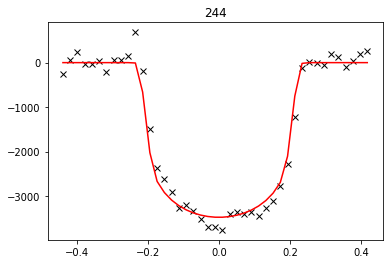

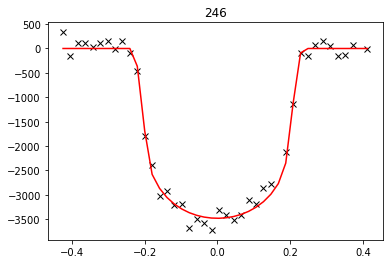

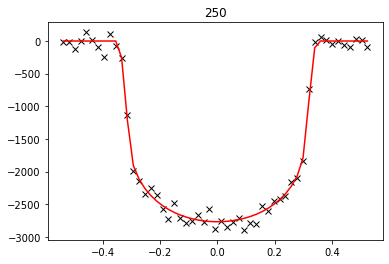

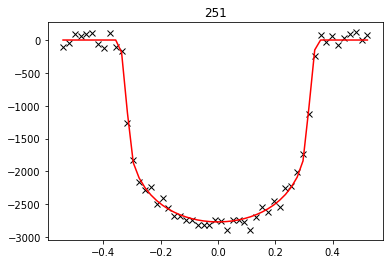

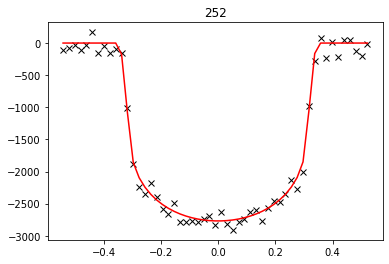

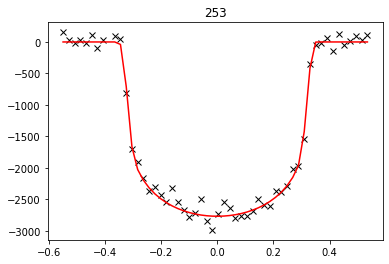

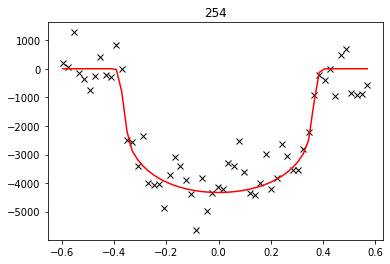

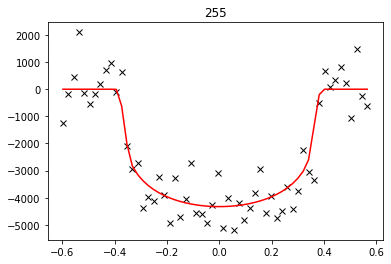

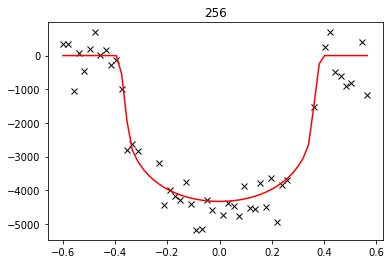

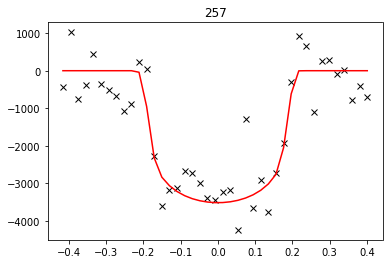

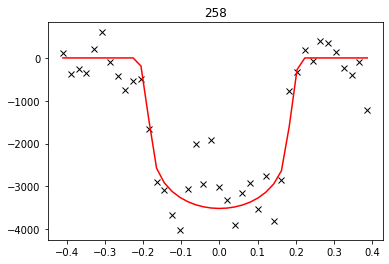

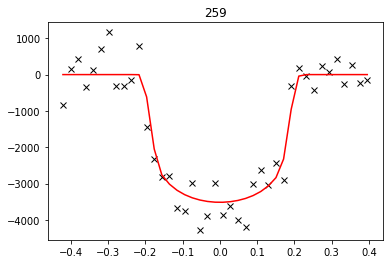

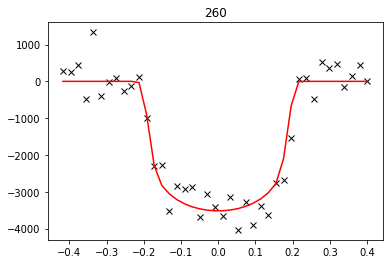

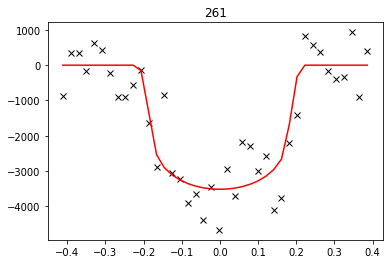

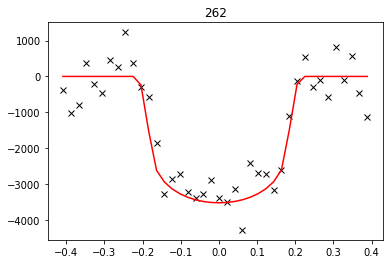

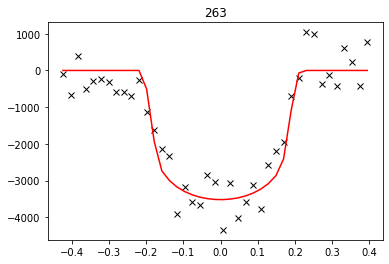

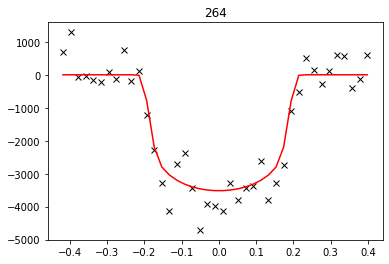

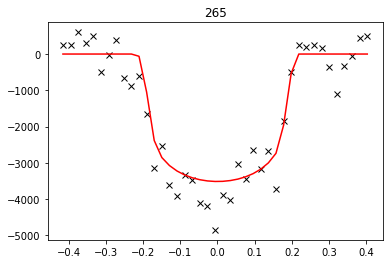

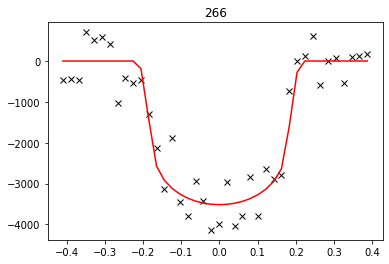

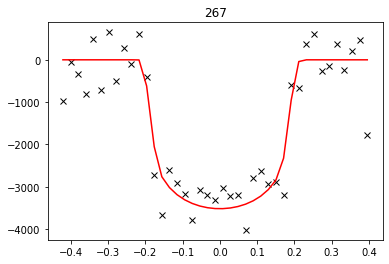

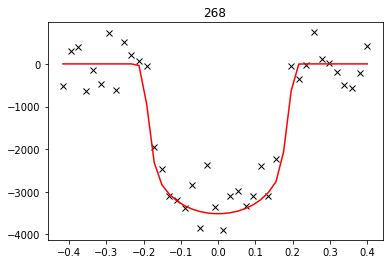

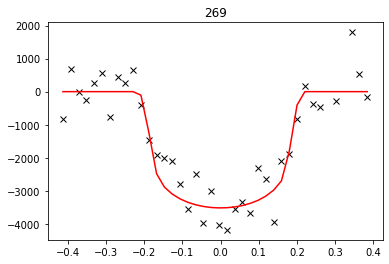

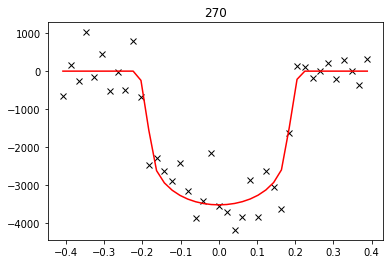

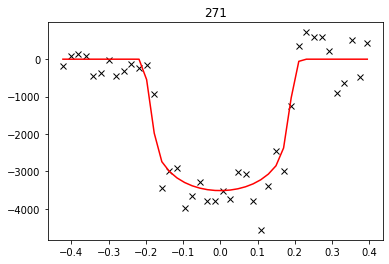

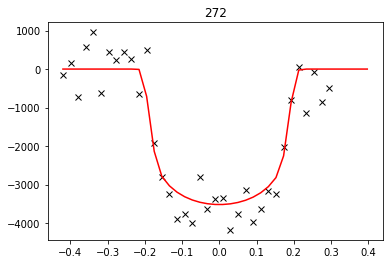

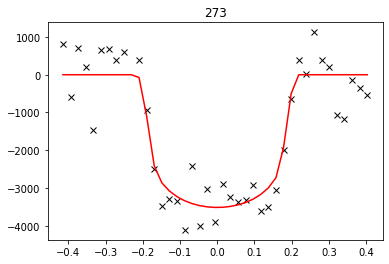

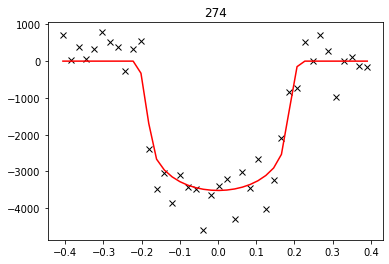

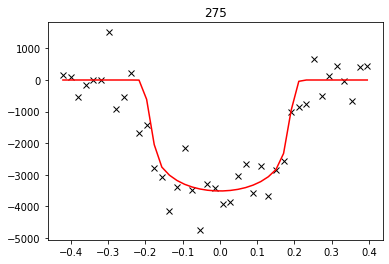

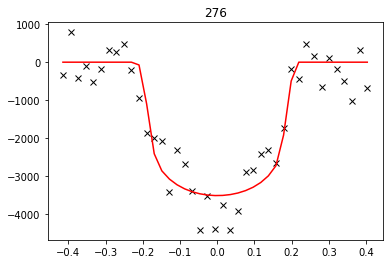

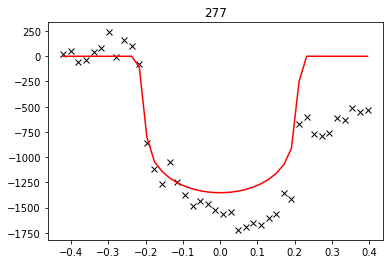

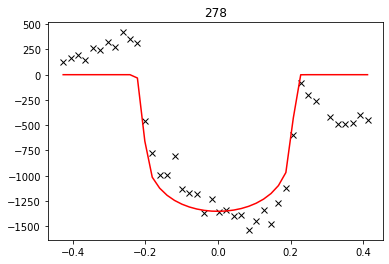

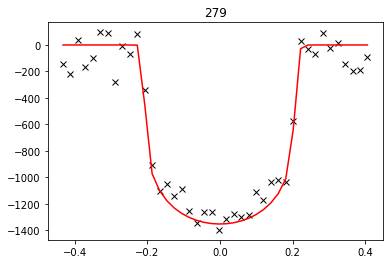

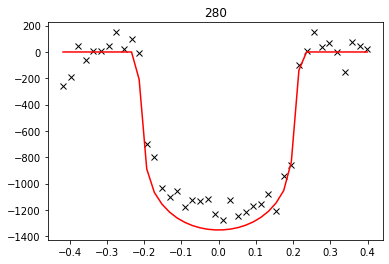

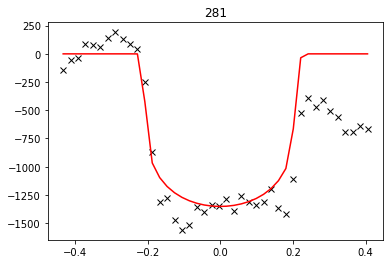

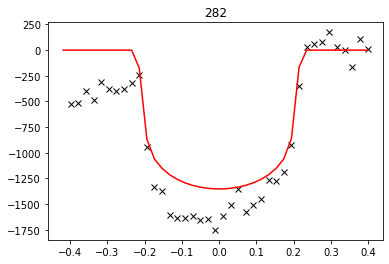

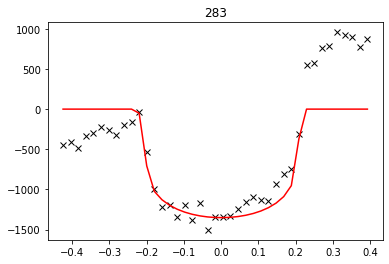

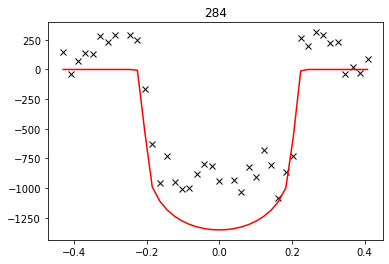

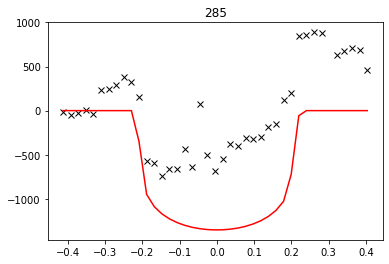

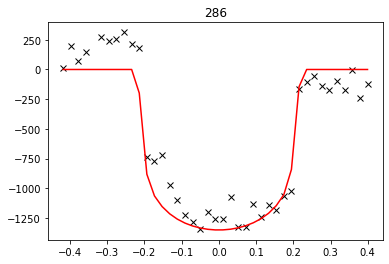

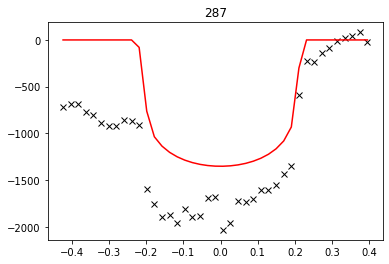

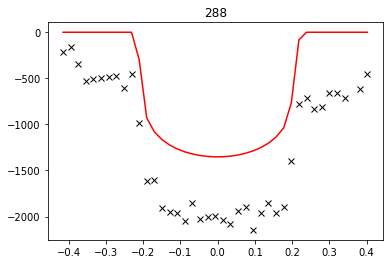

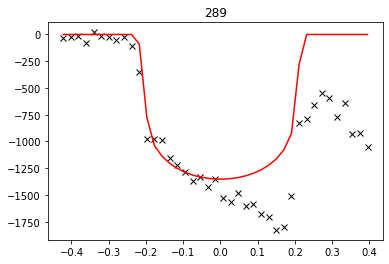

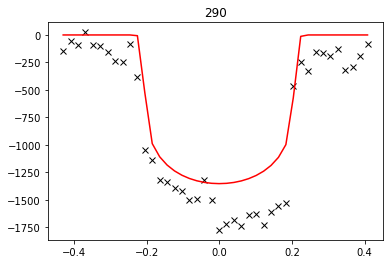

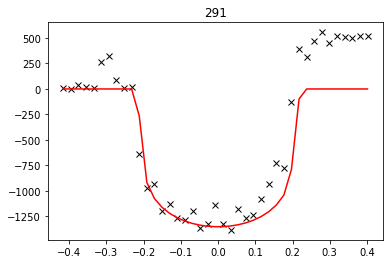

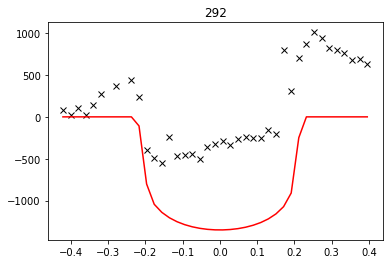

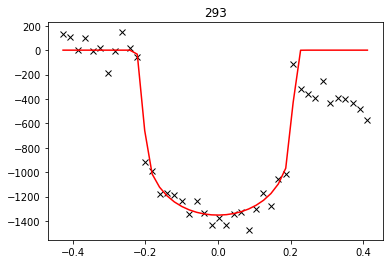

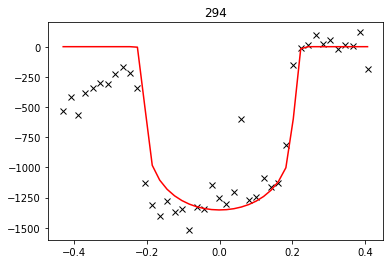

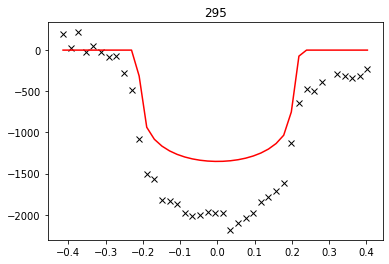

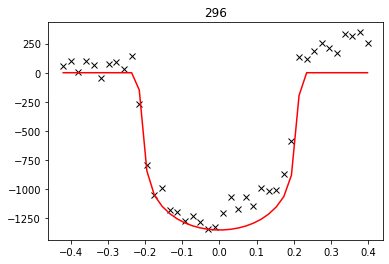

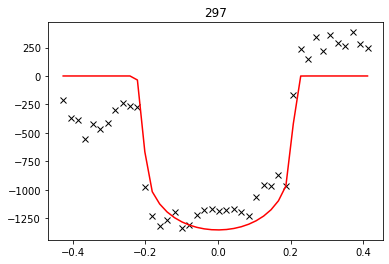

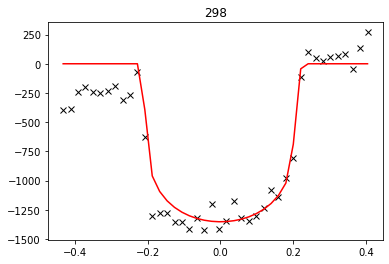

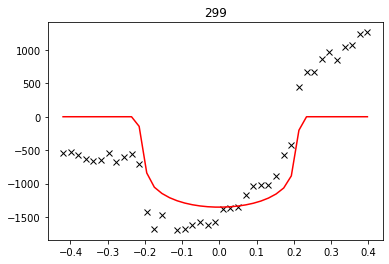

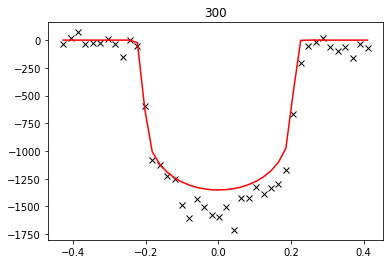

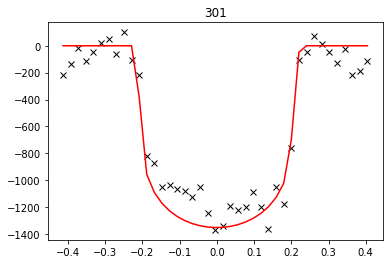

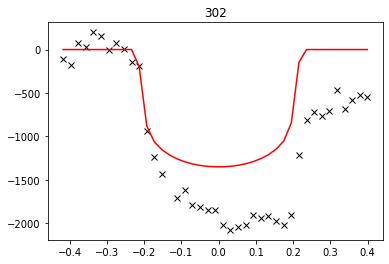

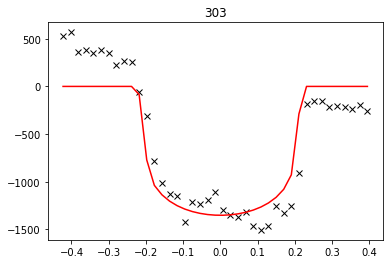

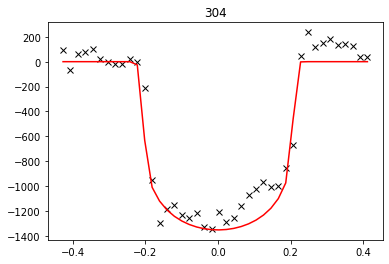

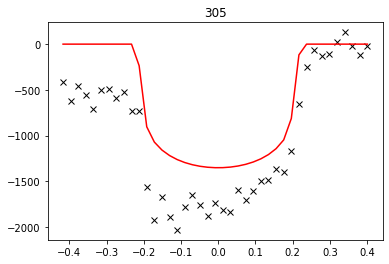

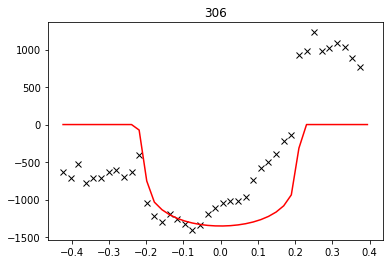

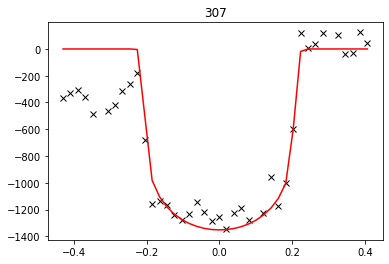

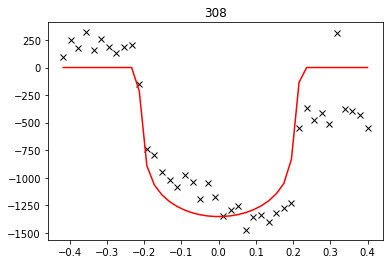

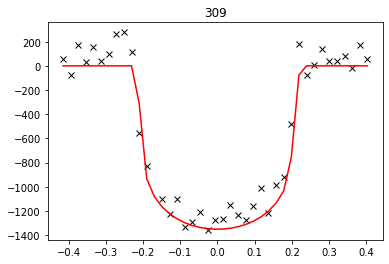

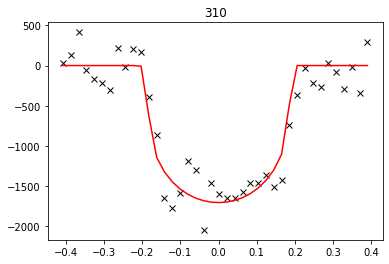

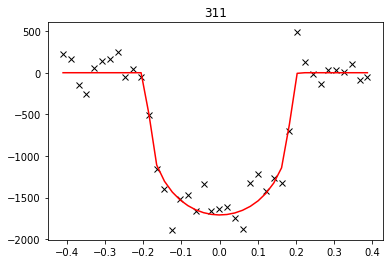

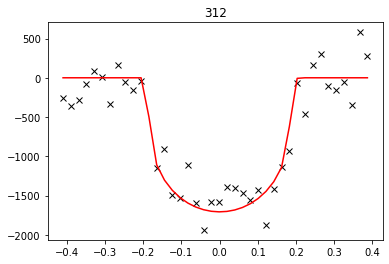

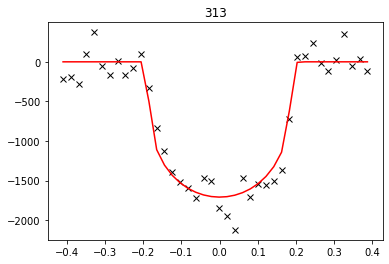

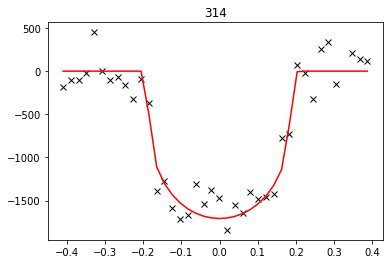

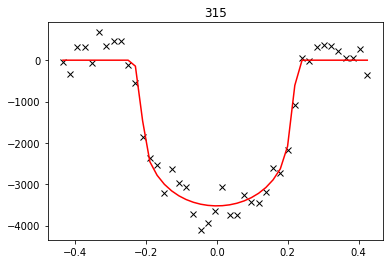

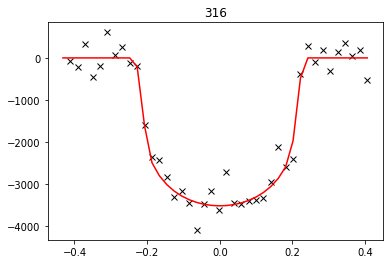

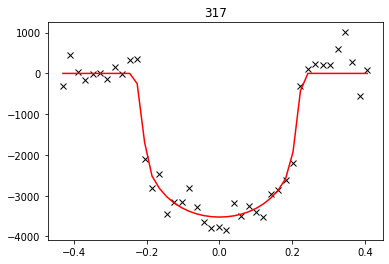

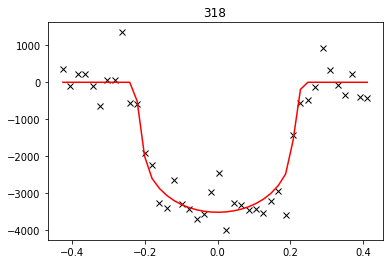

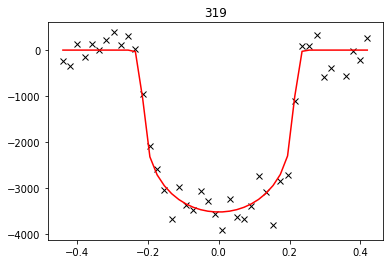

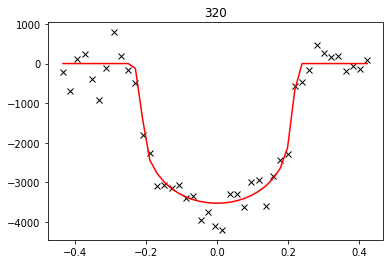

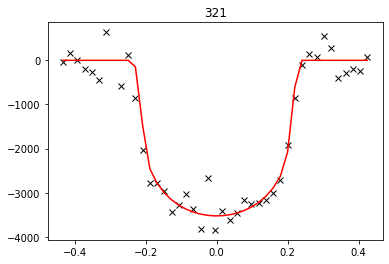

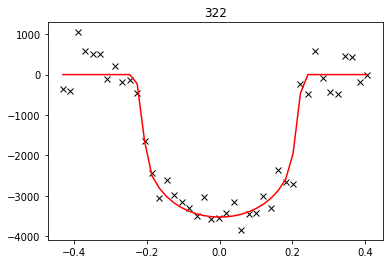

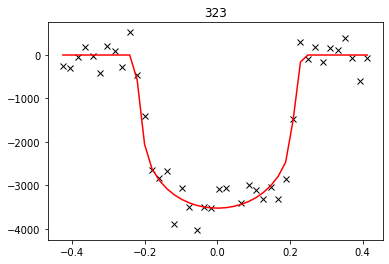

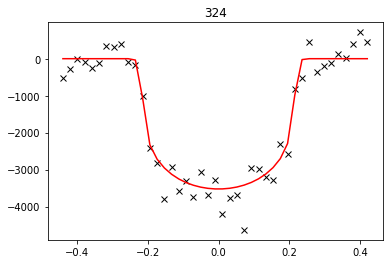

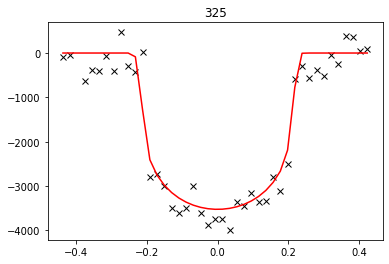

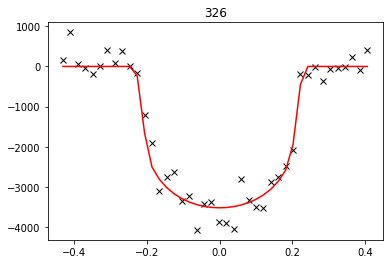

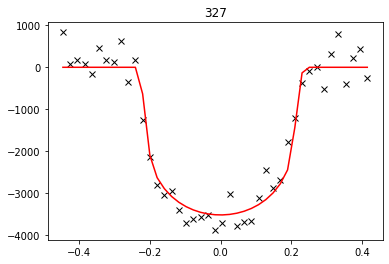

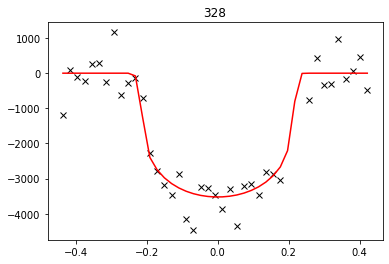

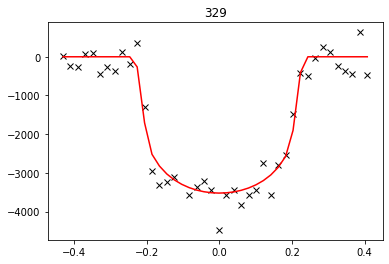

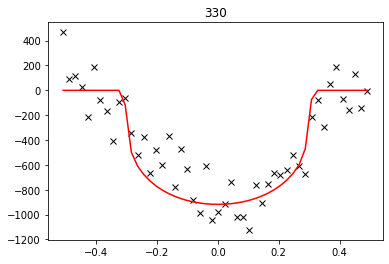

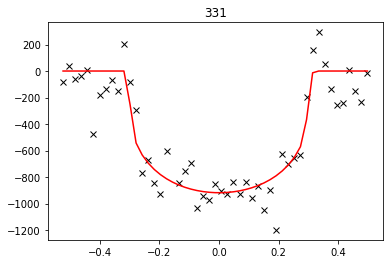

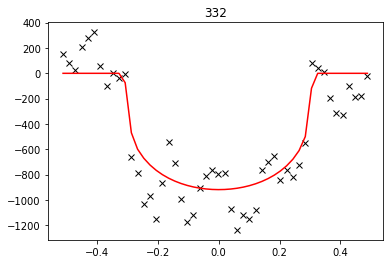

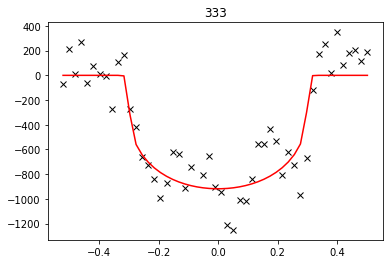

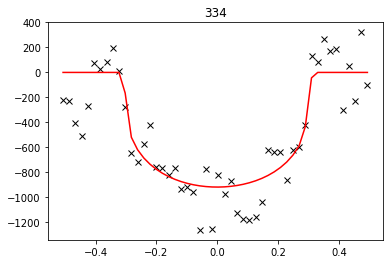

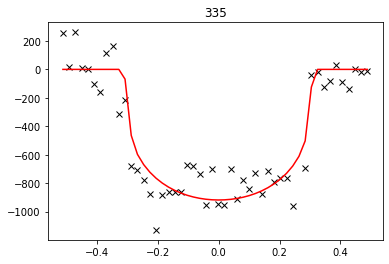

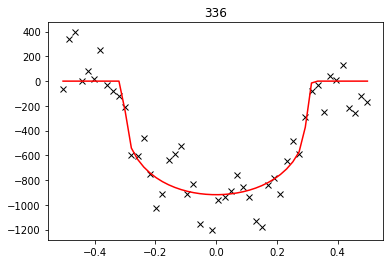

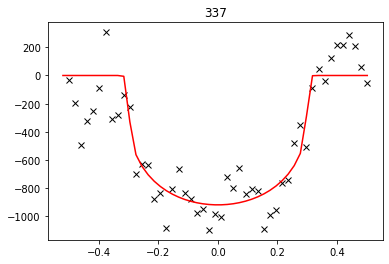

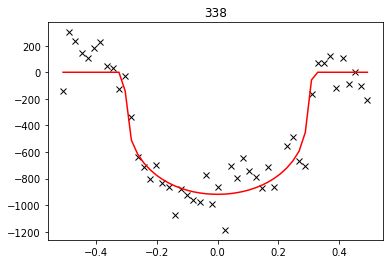

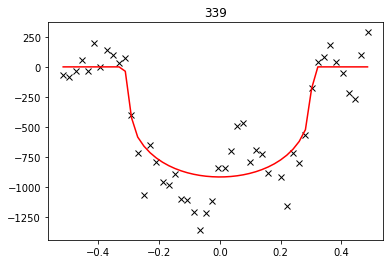

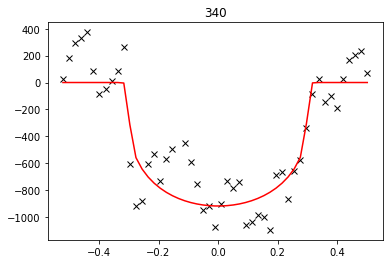

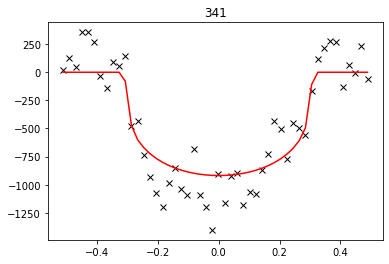

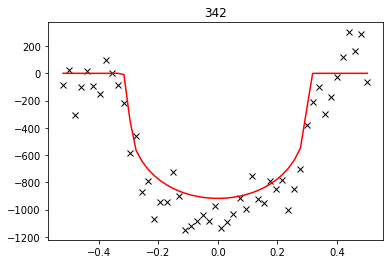

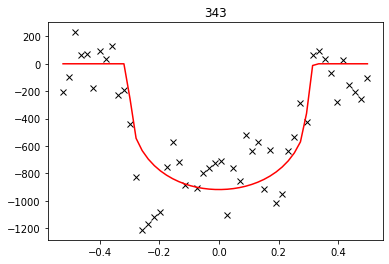

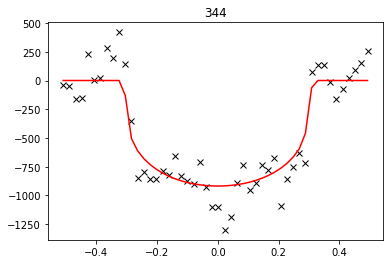

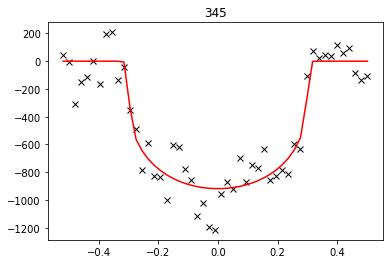

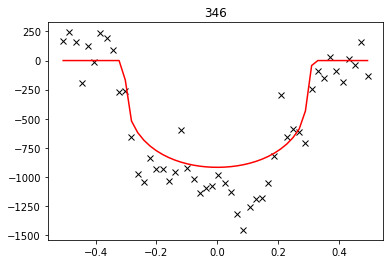

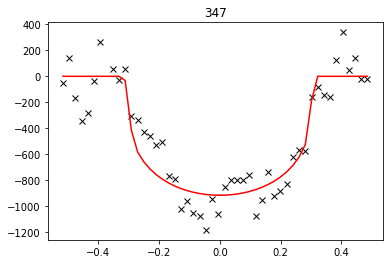

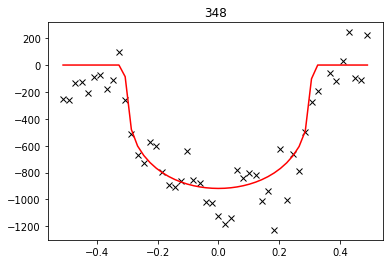

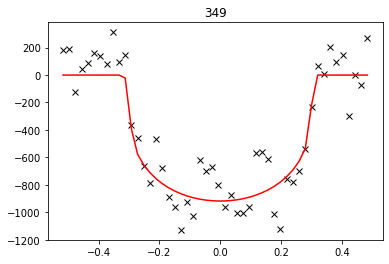

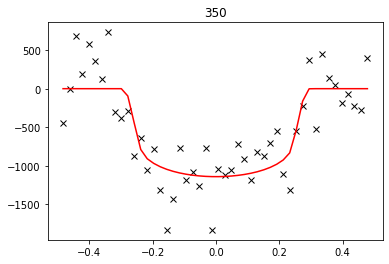

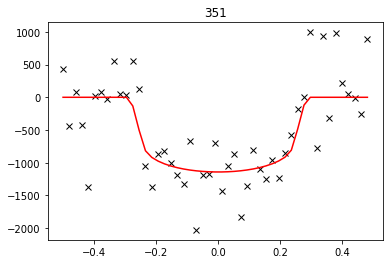

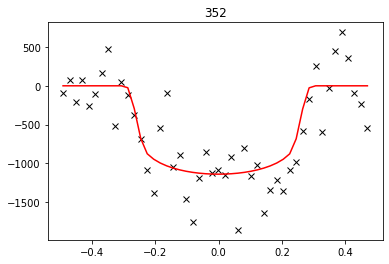

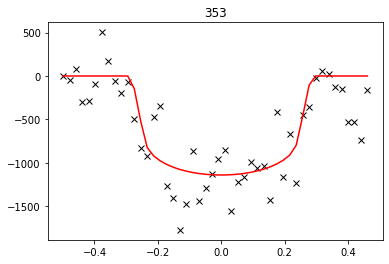

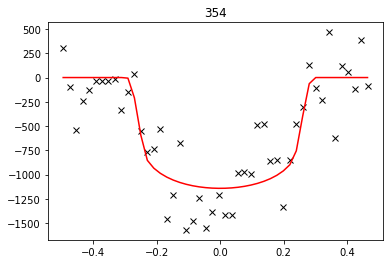

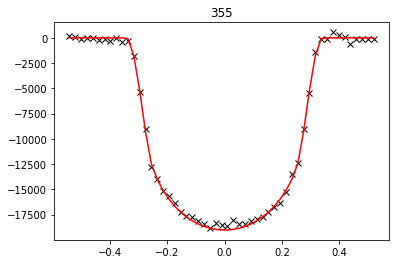

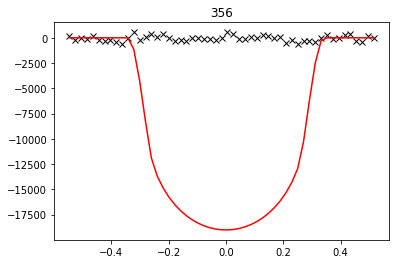

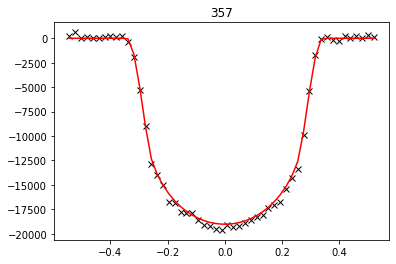

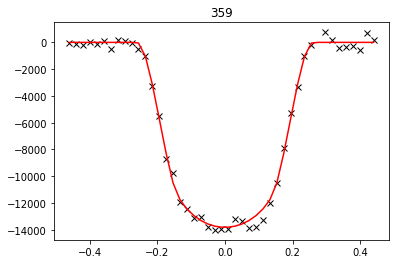

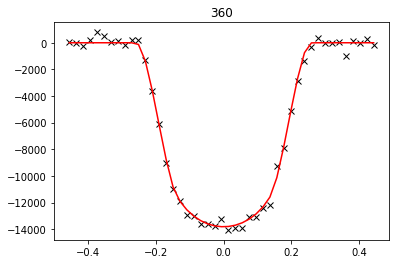

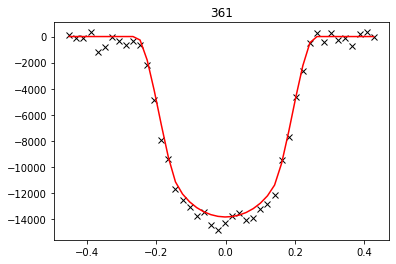

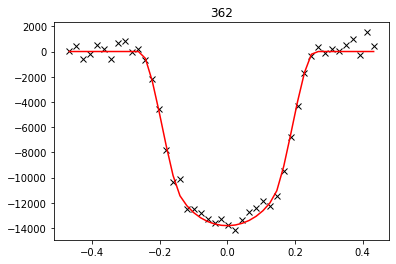

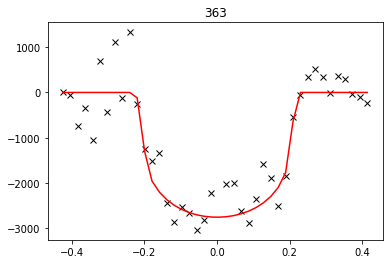

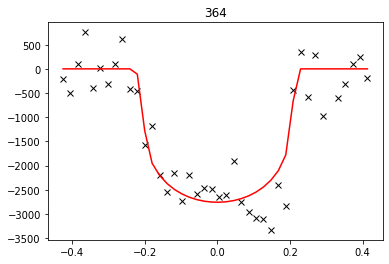

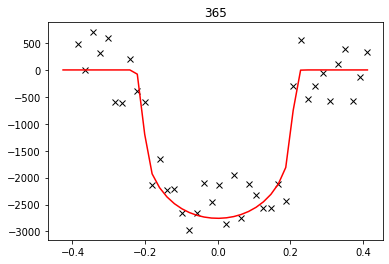

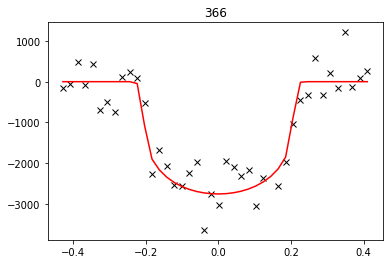

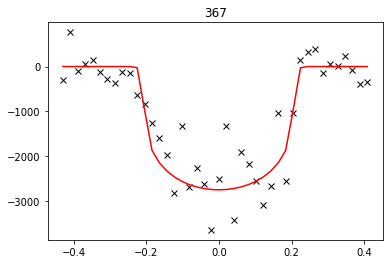

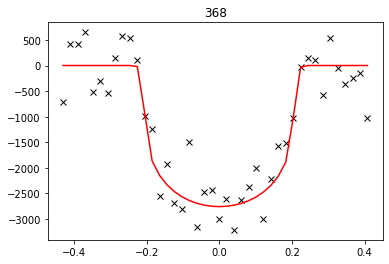

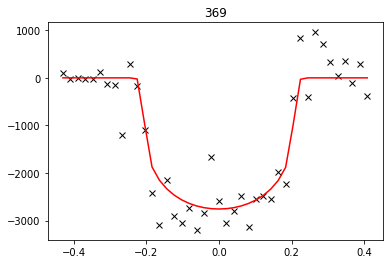

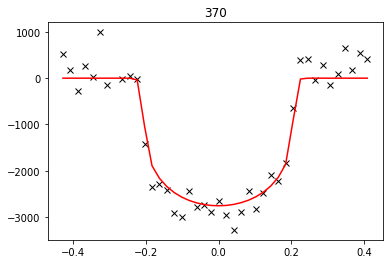

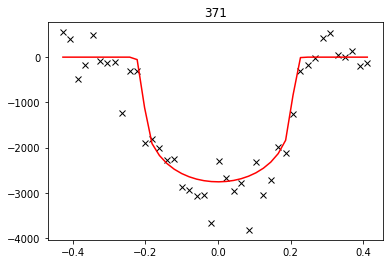

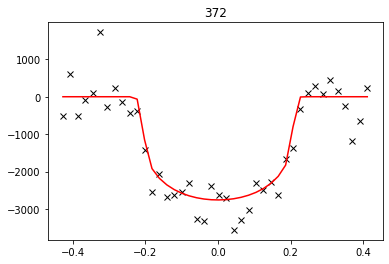

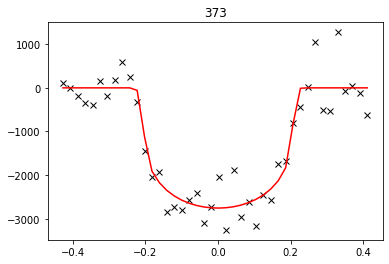

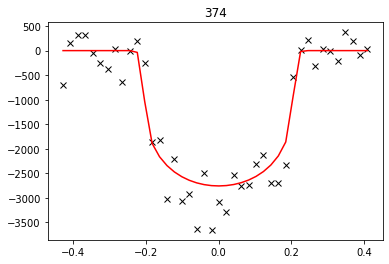

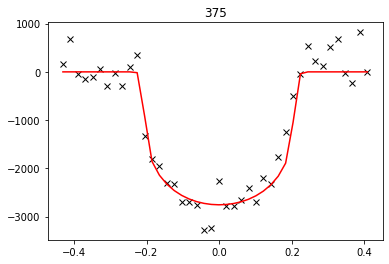

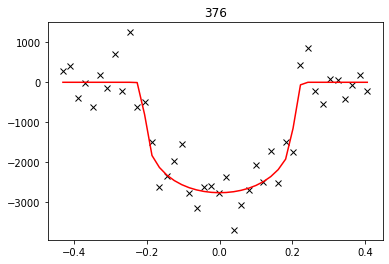

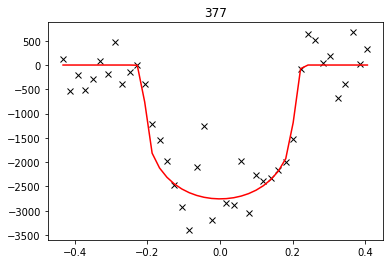

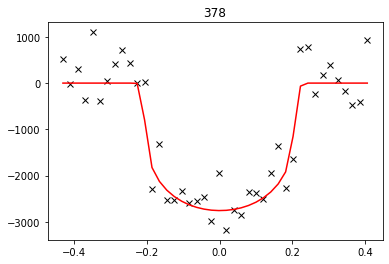

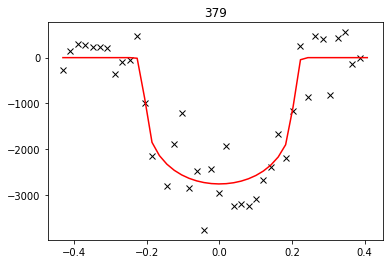

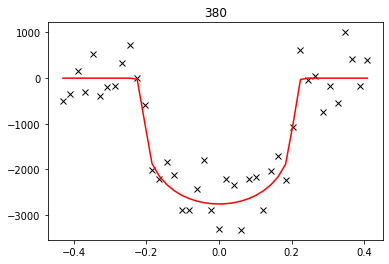

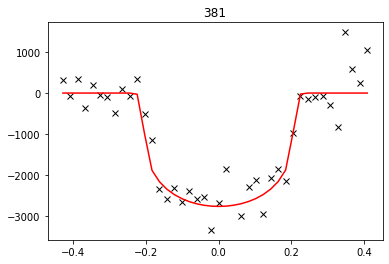

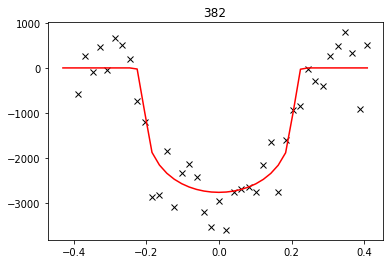

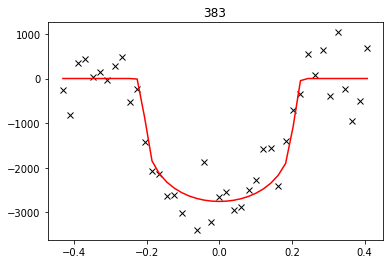

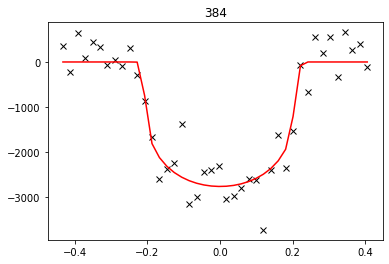

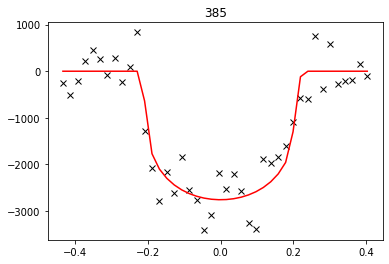

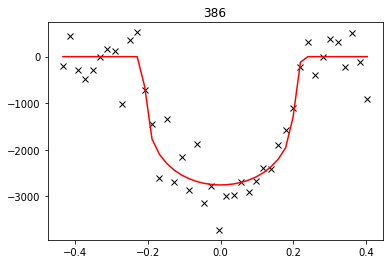

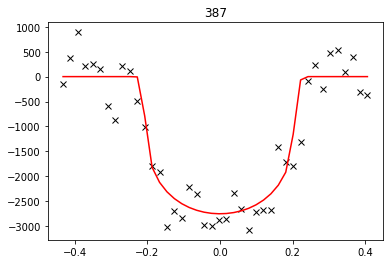

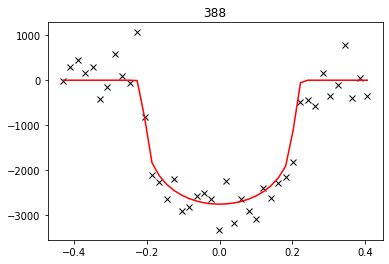

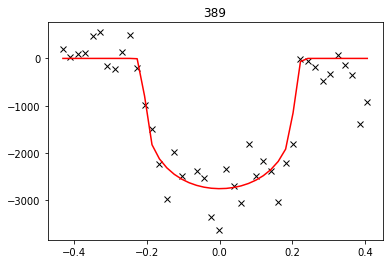

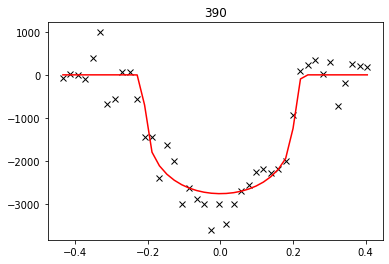

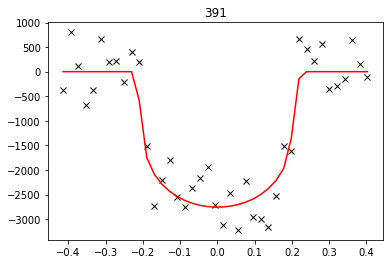

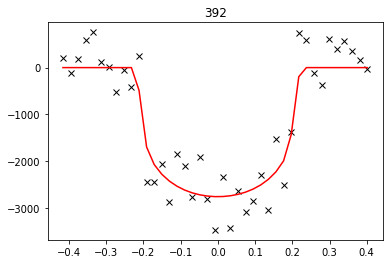

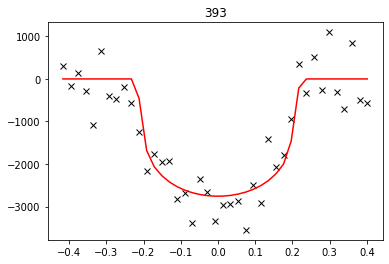

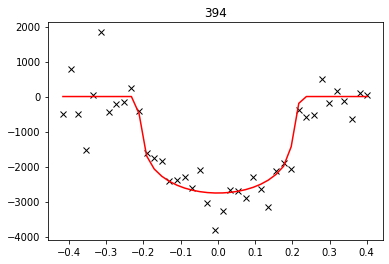

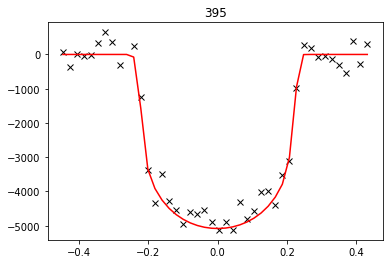

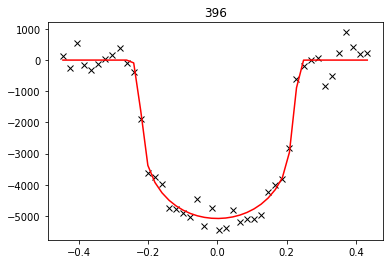

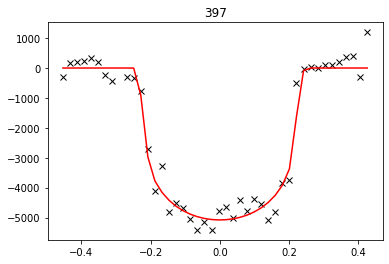

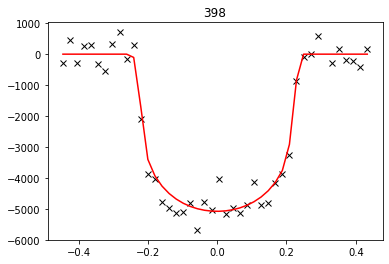

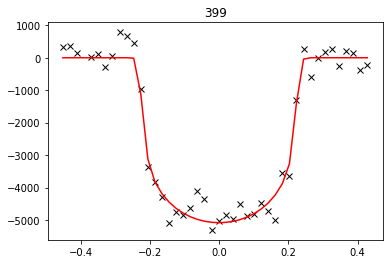

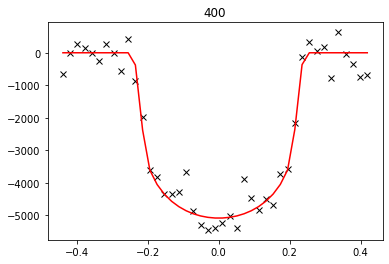

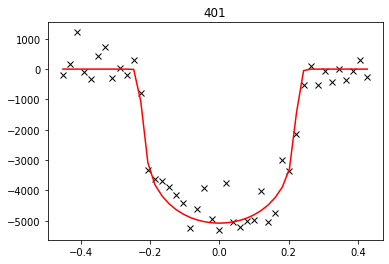

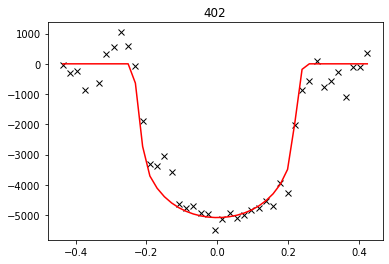

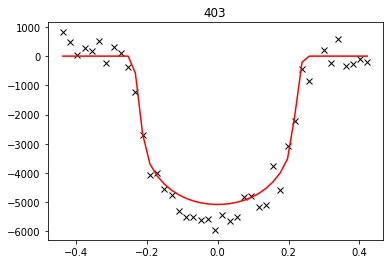

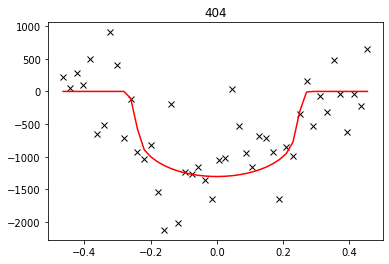

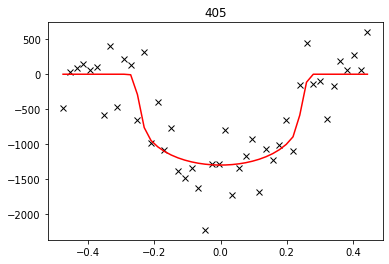

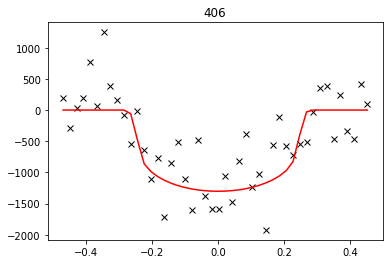

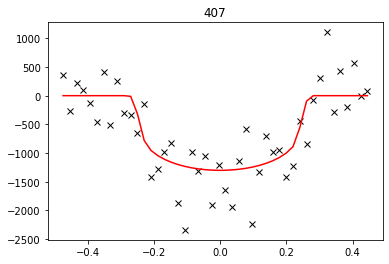

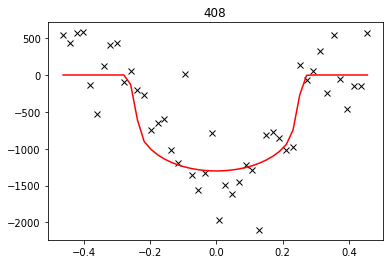

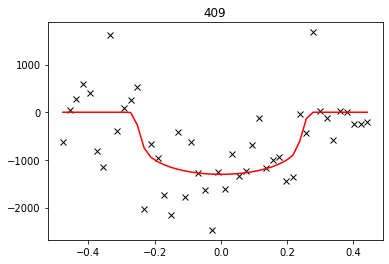

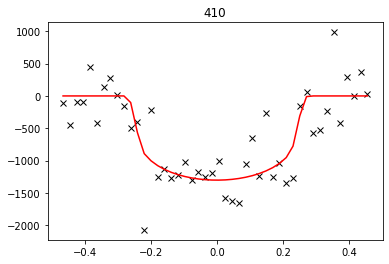

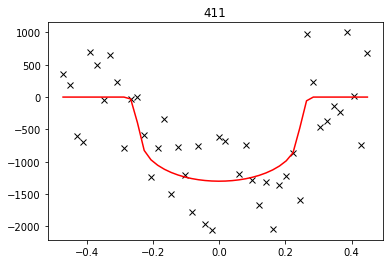

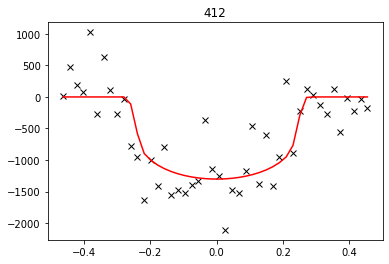

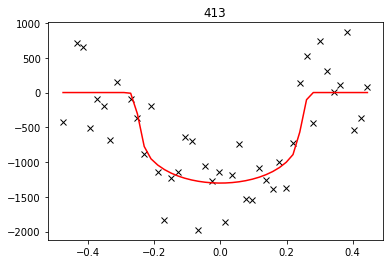

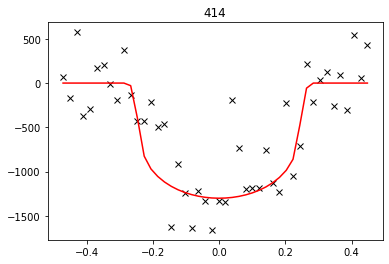

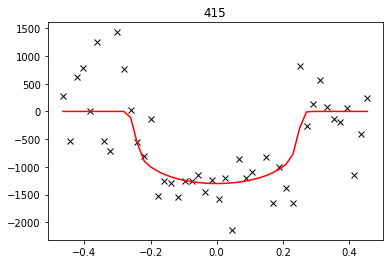

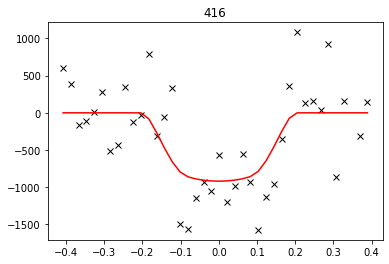

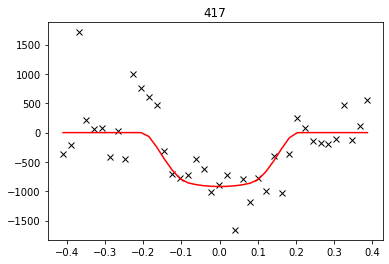

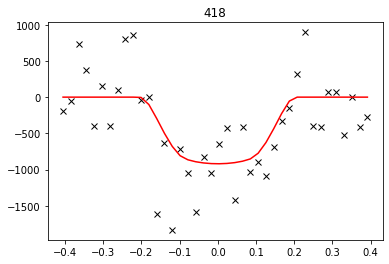

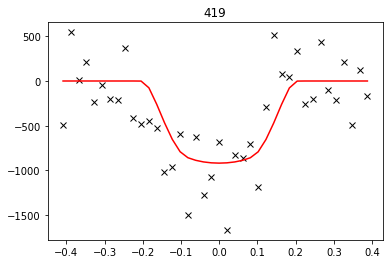

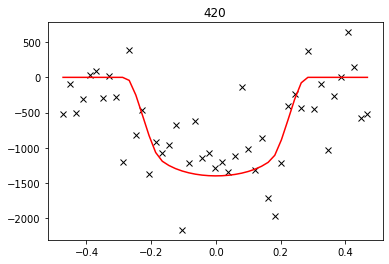

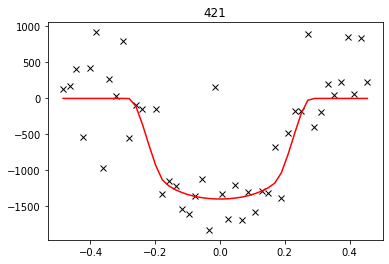

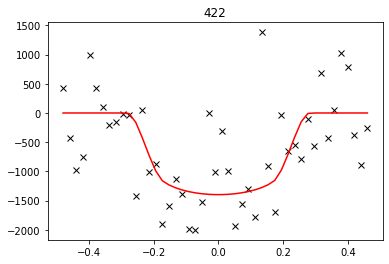

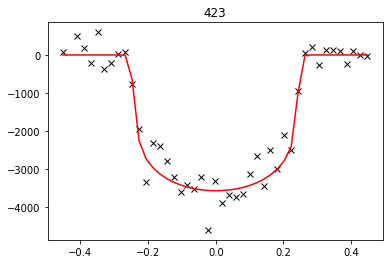

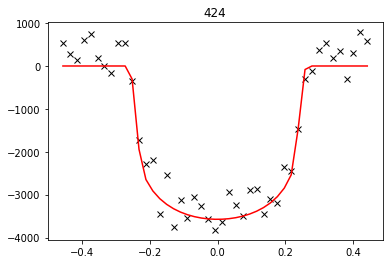

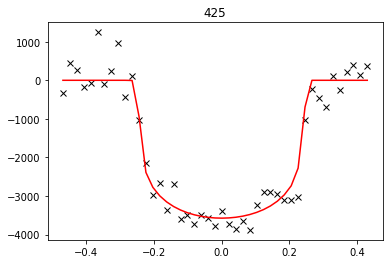

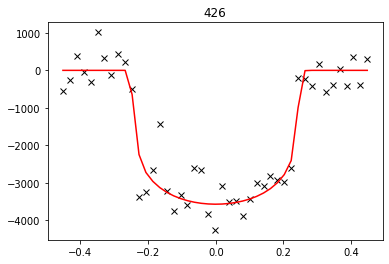

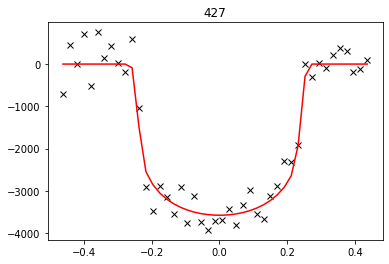

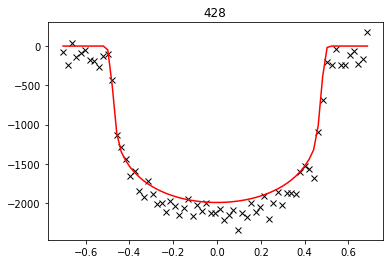

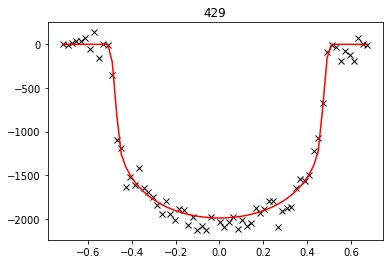

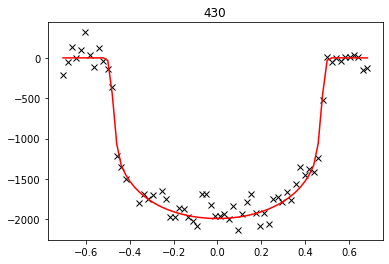

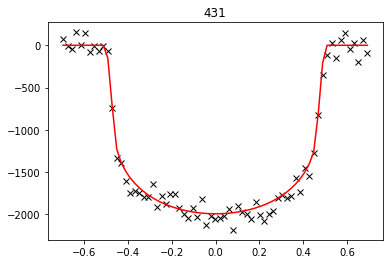

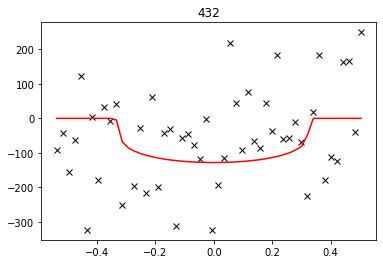

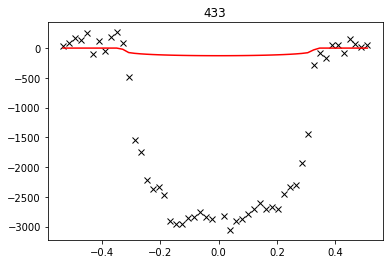

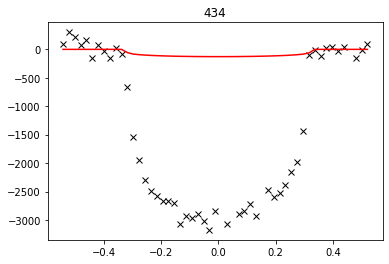

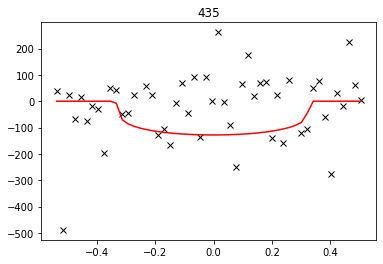

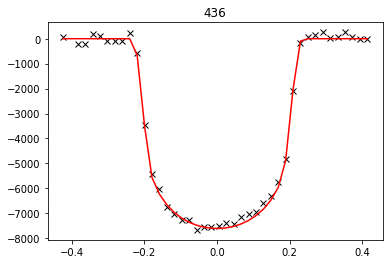

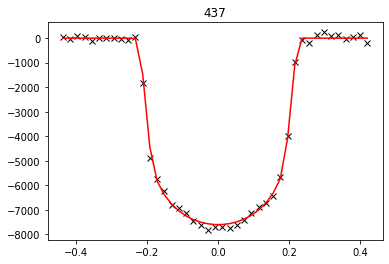

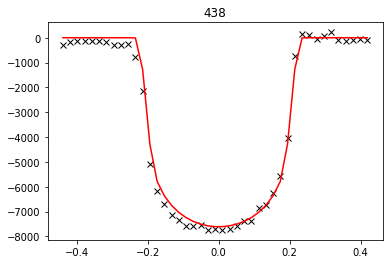

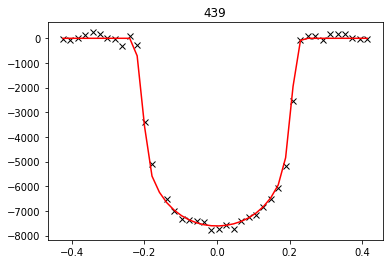

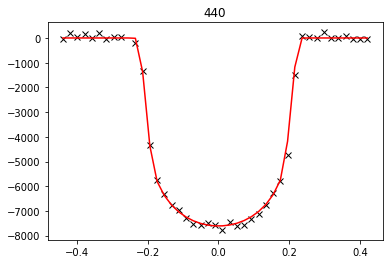

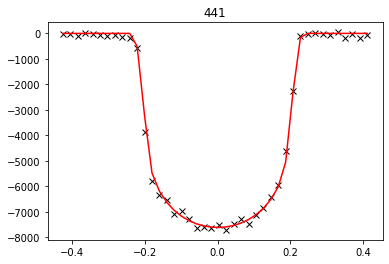

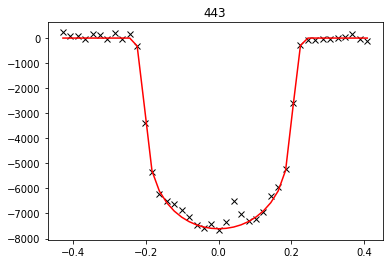

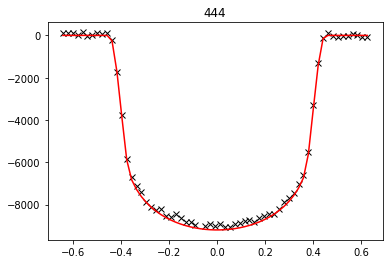

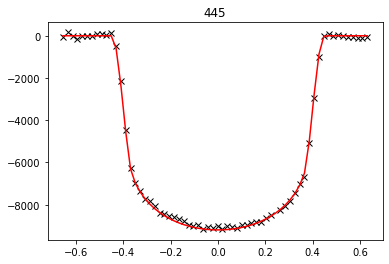

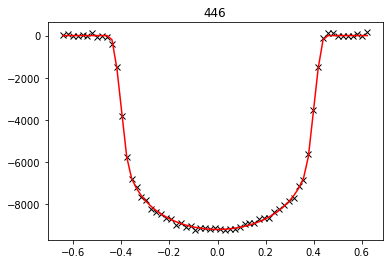

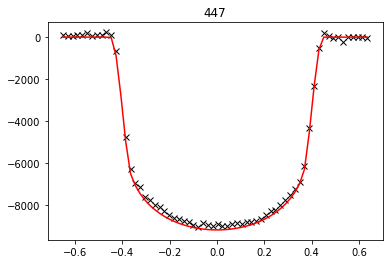

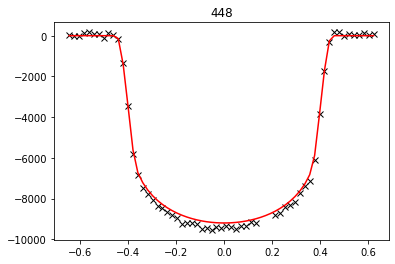

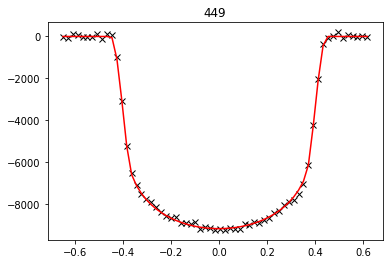

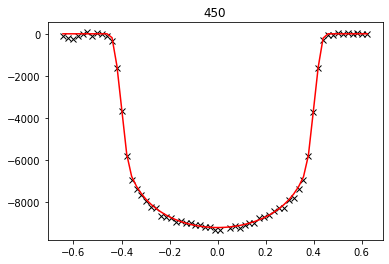

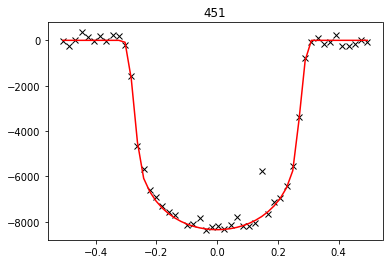

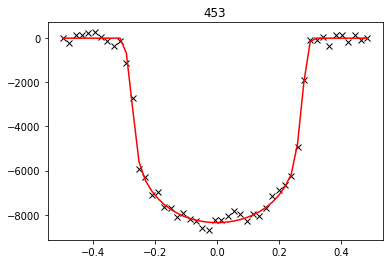

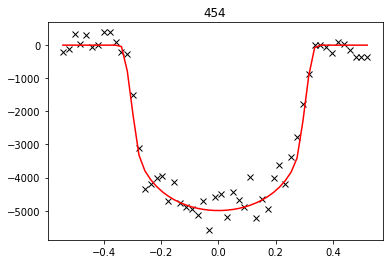

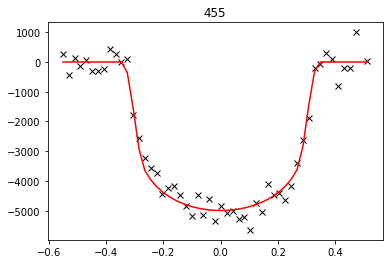

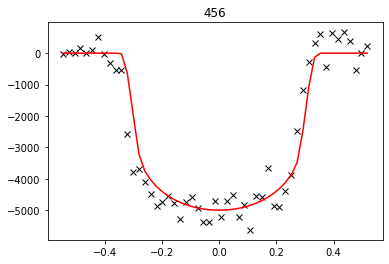

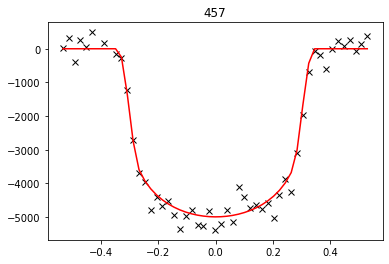

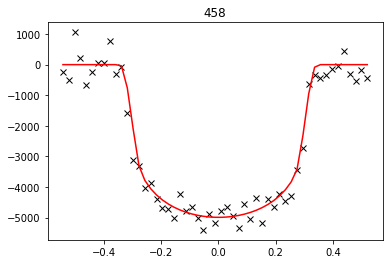

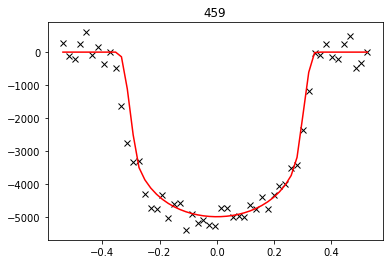

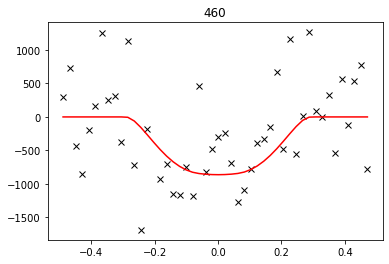

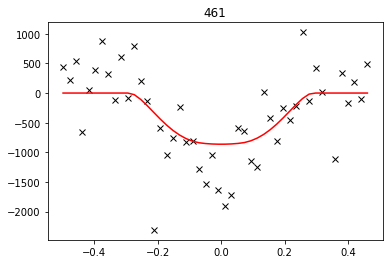

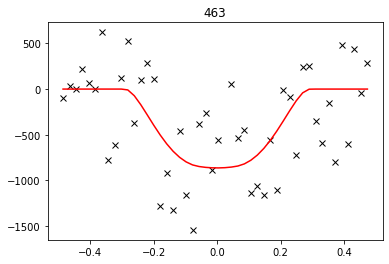

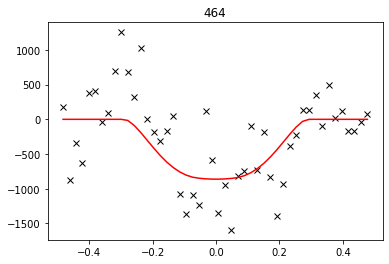

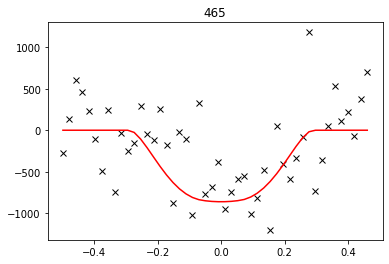

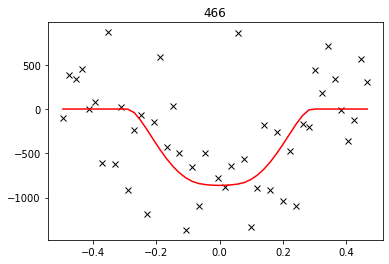

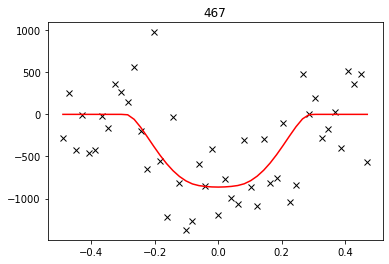

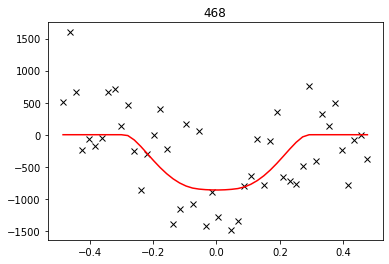

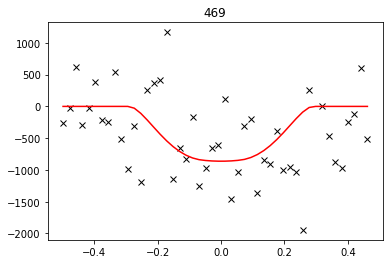

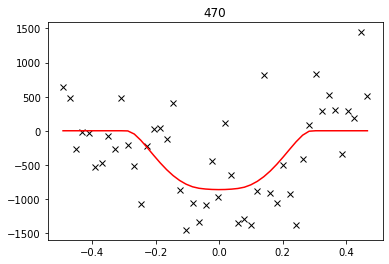

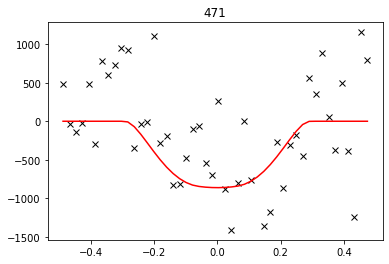

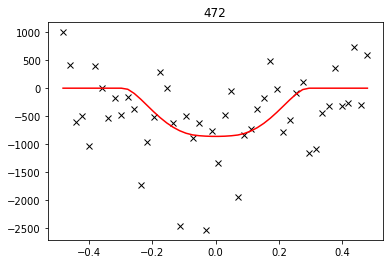

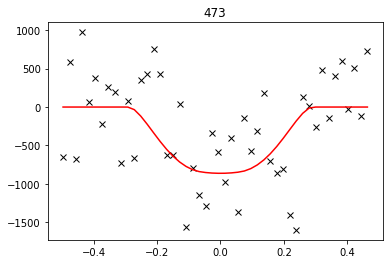

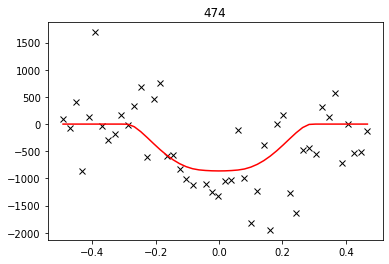

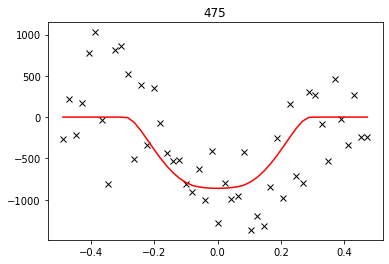

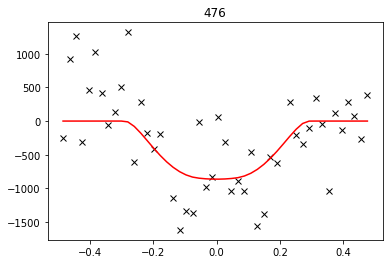

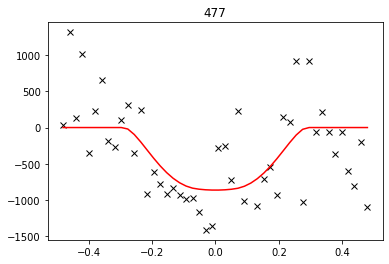

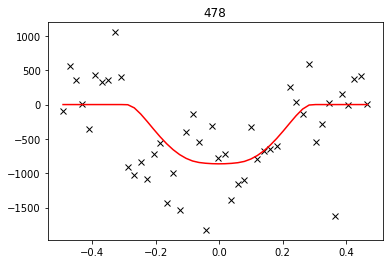

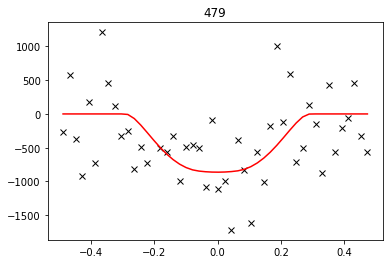

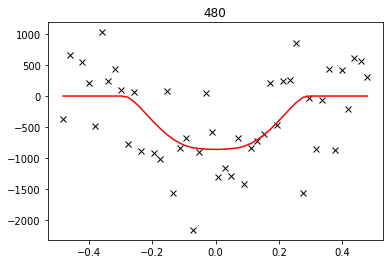

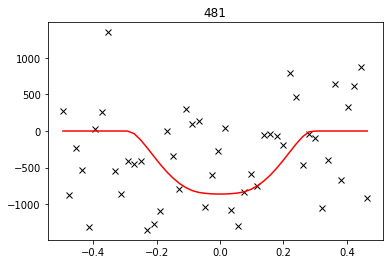

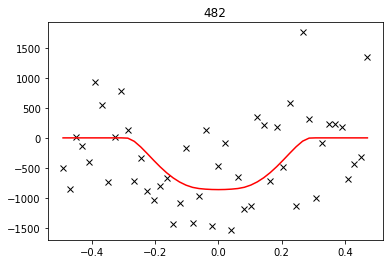

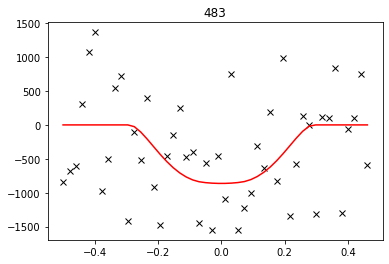

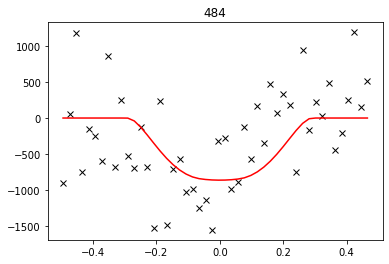

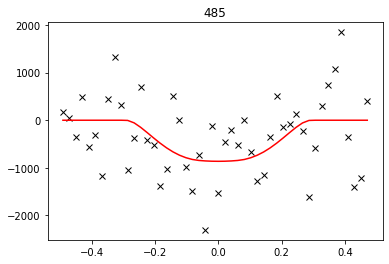

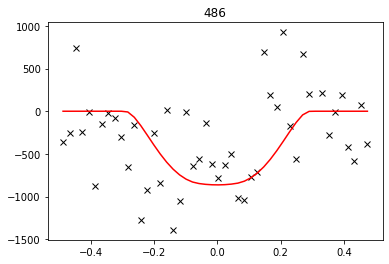

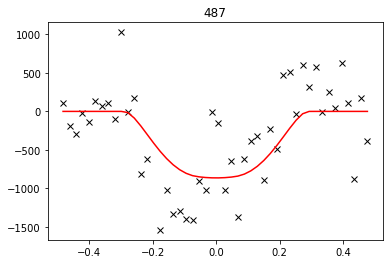

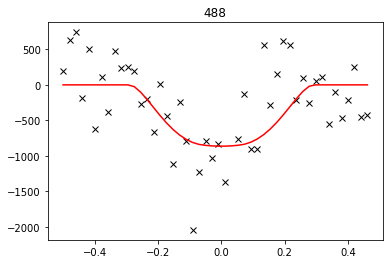

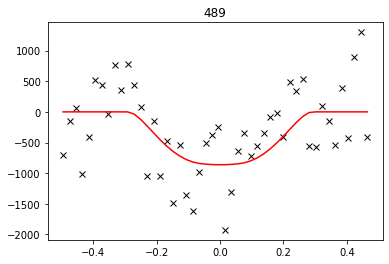

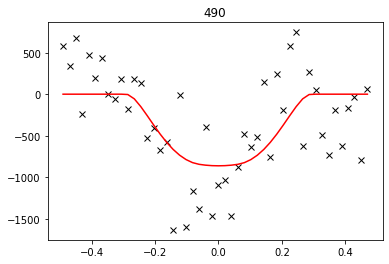

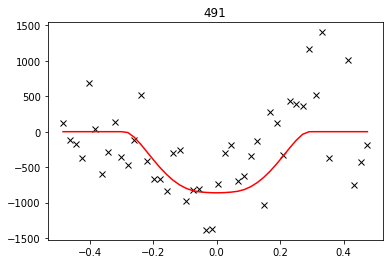

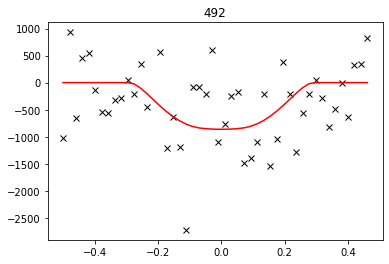

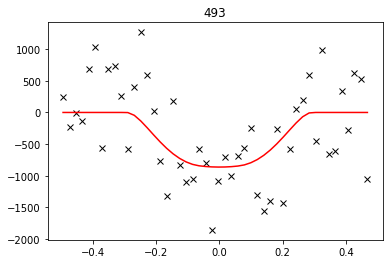

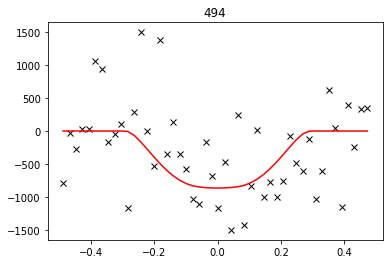

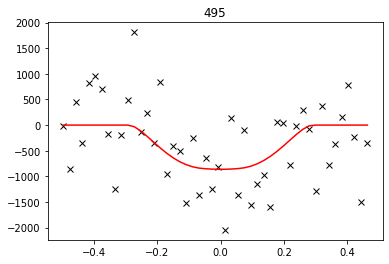

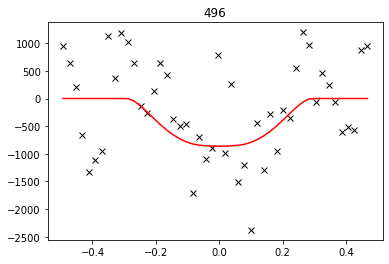

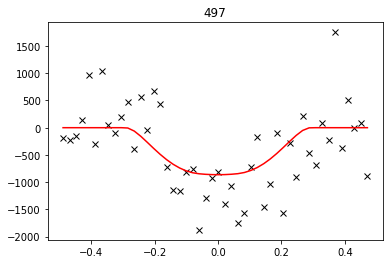

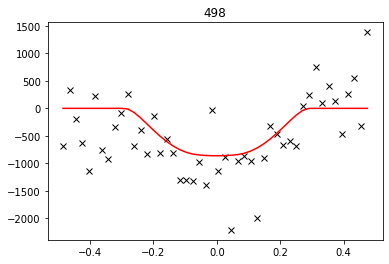

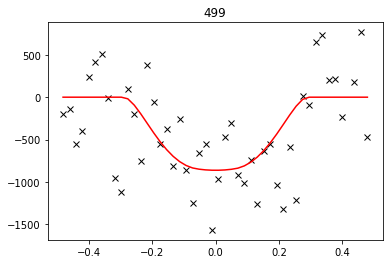

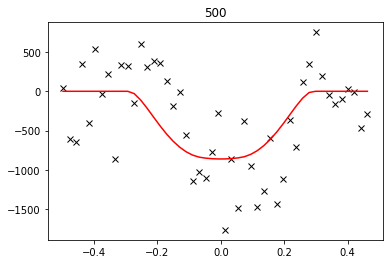

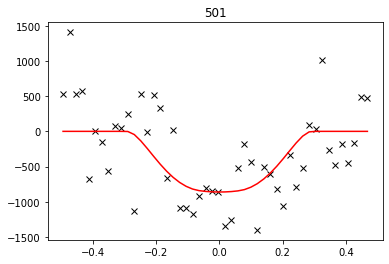

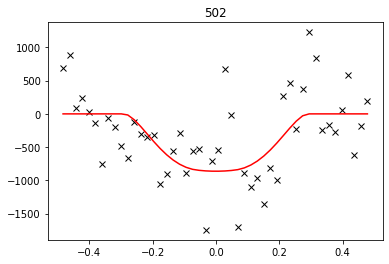

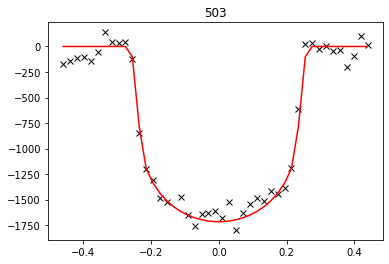

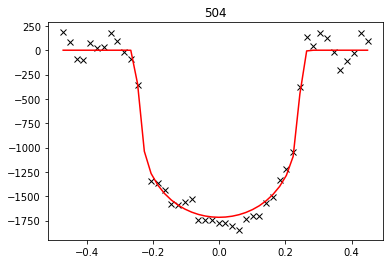

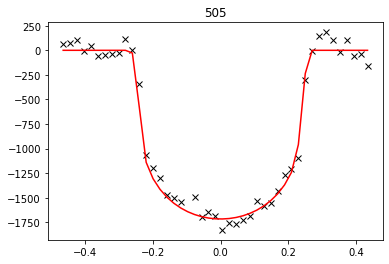

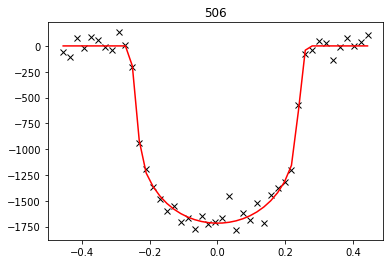

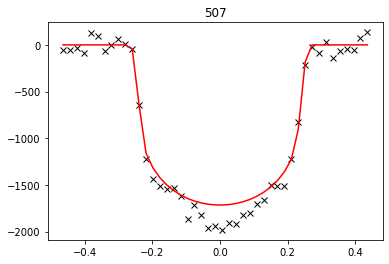

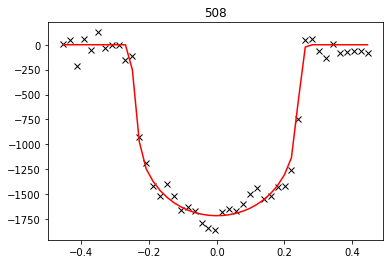

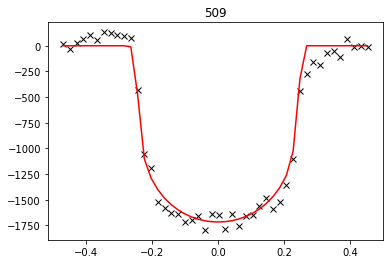

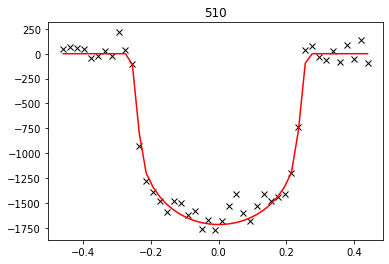

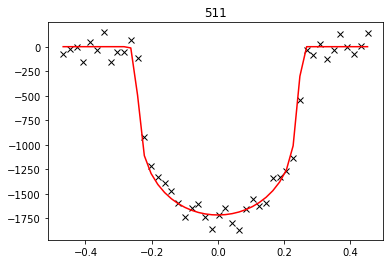

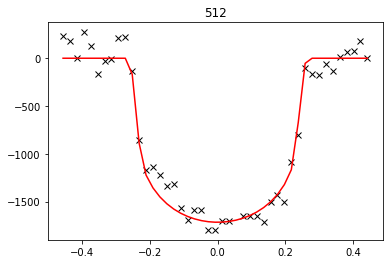

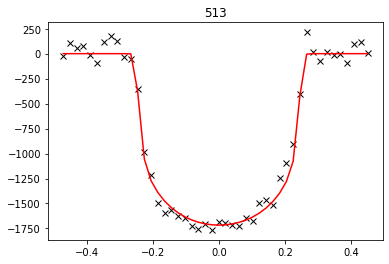

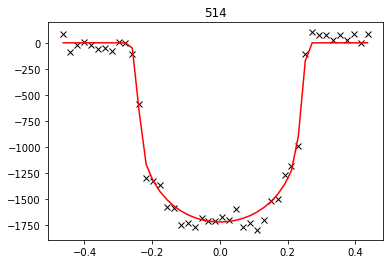

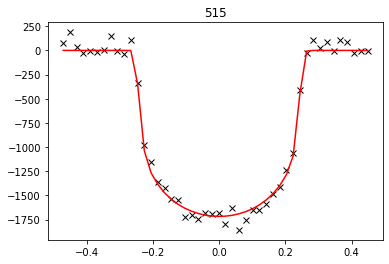

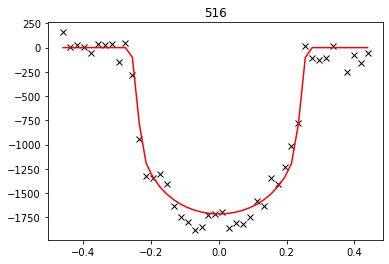

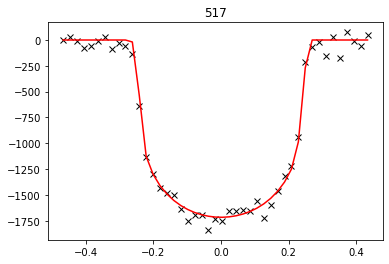

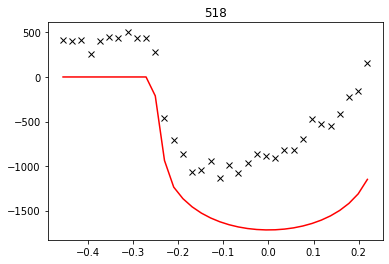

In [5]:

indexes = np.arange(outlier.size)[(outlier<0.03)]
#fig = plt.figure(figsize=(9,5))
for i in indexes:

    plt.title("%d"%(i))
    plt.plot(transit_phases[i],transit_fluxes[i]*1e6, 'x', color='black')
    plt.plot(transit_phases[i],transit_models[i]*1e6, color='red')
    plt.show()

AxesSubplot(0.766379,0.125;0.133621x0.755)


/home/jacob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


42


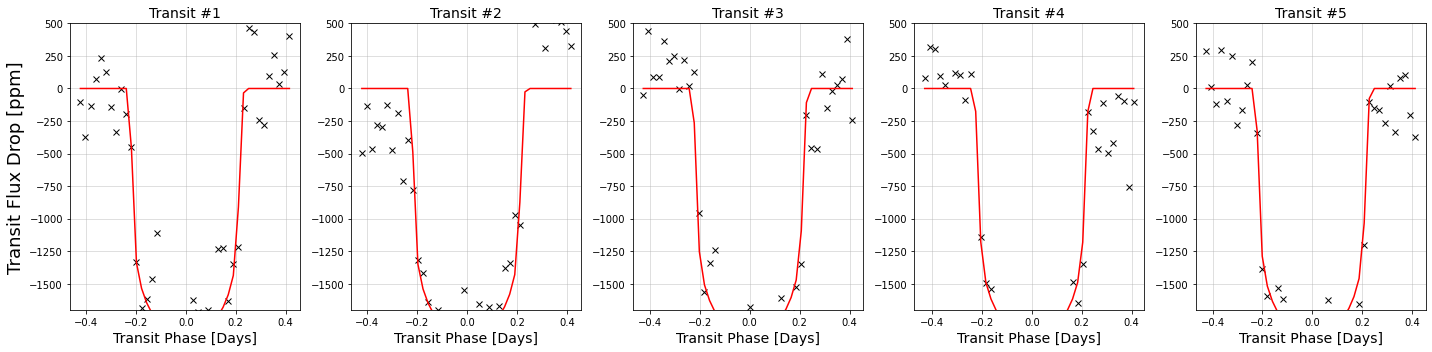

In [6]:

fig = plt.figure(figsize=(20,5))
ax = plt.subplot(155)
print(ax)
for i in range(30,35):
    ax = plt.subplot(1,5,i-29)
    ax.plot(transit_phases[i],transit_fluxes[i]*1e6, 'x', color='black')
    plt.title("Transit #%d"%(i-29),size=14)
    ax.plot(transit_phases[i],transit_models[i]*1e6, color='red')
    plt.ylim(-1700,500)
    plt.grid(alpha = 0.5)
    if(i == 30):
        plt.ylabel("Transit Flux Drop [ppm]",size=18)
    plt.xlabel("Transit Phase [Days]",size=14)
plt.tight_layout()
plt.savefig("Transit_stellar_activity.png")
print(transit_phases[30].size)
plt.show()

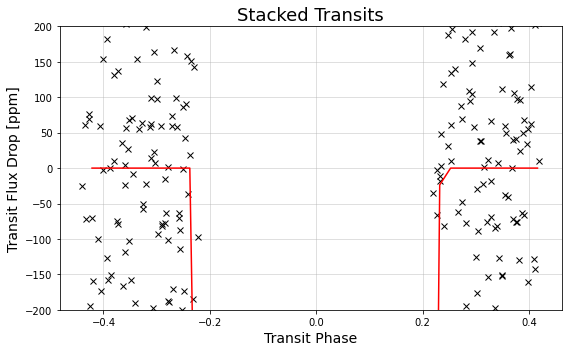

In [7]:
fig = plt.figure(figsize=(8,5))
stacked_phases = np.array(transit_phases[0])
stacked_fluxes = np.array(transit_fluxes[0])
for i in range(1,14):

    
    stacked_phases = np.append(stacked_phases,np.array(transit_phases[i]))
    stacked_fluxes = np.append(stacked_fluxes,np.array(transit_fluxes[i]))
    
plt.plot(stacked_phases,stacked_fluxes*1e6, 'x', color='black')
plt.plot(transit_phases[0],transit_models[0]*1e6, color='red')  

plt.ylim(-200,200)
plt.title("Stacked Transits",size=18)
plt.ylabel("Transit Flux Drop [ppm]",size=14)
plt.xlabel("Transit Phase",size=14)
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.savefig("Transit_stacked.png")
np.save("stacked_phase",stacked_phases)
np.save("stacked_fluxes",stacked_fluxes)
plt.show()

In [8]:
delta_t = []
for i in range(len(periods)):
    p = periods[i]
    for transit in transit_phases:
        for j in range(len(transit)-1):
            tmp = np.array(transit)
            delta_t.append((tmp[j+1]-tmp[j]))

In [9]:
delta_t_sec = np.array(delta_t)*24*3600
mu = np.mean(delta_t_sec)
std = np.std(delta_t_sec)

1765.4683


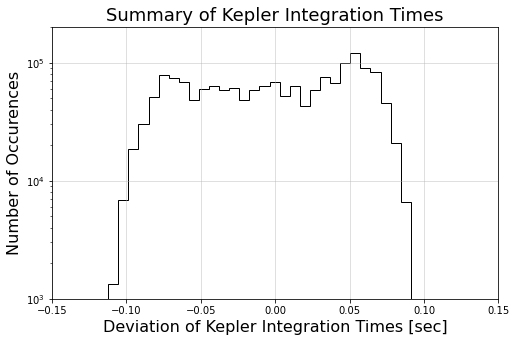

In [18]:
plt.figure(figsize=(8,5))
print(np.mean(delta_t_sec))
plt.hist(delta_t_sec - np.mean(delta_t_sec),bins=300,density=False,histtype='step',color="black")
plt.grid(alpha=0.5)
#plt.xlim(mu-3*std,mu+3*std)
plt.axvline(x = 30*60, color='red')
plt.xlim(-0.15,0.15)
plt.ylim(1e3,2e5)
plt.yscale('log')
plt.ylabel("Number of Occurences",size=16)
plt.xlabel("Deviation of Kepler Integration Times [sec]",size=16)
plt.title("Summary of Kepler Integration Times",size=18)
plt.savefig("KeplerIntTimes.png")
plt.show()

In [11]:
print (mu,std)

1765.4683 0.052668985


In [12]:
dat = Table.read(filenames[0], format='fits')
df = dat.to_pandas()

In [13]:
print(transit_phases[30])

1648   -0.422894
1649   -0.402461
1650   -0.382029
1651   -0.361596
1652   -0.341164
1653   -0.320731
1654   -0.300299
1655   -0.279866
1656   -0.259433
1657   -0.239001
1658   -0.218568
1659   -0.198136
1660   -0.177703
1661   -0.157271
1662   -0.136838
1663   -0.116405
1664   -0.095973
1665   -0.075540
1666   -0.055108
1667   -0.034675
1668   -0.014243
1669    0.006190
1670    0.026623
1671    0.047055
1672    0.067488
1673    0.087920
1674    0.108353
1675    0.128785
1676    0.149218
1677    0.169651
1678    0.190083
1679    0.210516
1680    0.230948
1681    0.251381
1682    0.271814
1683    0.292246
1684    0.312679
1685    0.333111
1686    0.353544
1687    0.373976
1688    0.394409
1689    0.414842
Name: PHASE, dtype: float32
